# Data Analysis 3 - First Home Assignment
## Author: Márton Nagy

For full repository with all needed files (if you do not want to run the model training, but only import their results from DILL files), please refer to my [public GitHub repository](https://github.com/marton-nagy-marton/Data-Analysis-3/tree/main/Home_Assignment_1).

## Part 1: Modelling
### 1.1. - Data wrangling

In [ ]:
# general packages
import pandas as pd
import numpy as np
import math
import ast
from datetime import datetime
from time import time
from pathlib import Path
import dill
import json

# plotting
from plotnine import *
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg
import patchworklib as pw
from IPython.display import display
from mizani.formatters import percent_format

# data analysis
from patsy import dmatrices
from sklearn.compose import ColumnTransformer
from sklearn.inspection import partial_dependence, permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import shap

# other
import warnings
import zipfile
warnings.filterwarnings("ignore")
%matplotlib inline

from utils.py_helper_functions import *

My chosen AirBnB dataset is: Milan (2024Q2). I will check the validity of my models on data from Milan (2024Q3) and Florence (2024Q2).

First, I read the raw CSV files (as they have been downloaded from the InsideAirBnB website).

In [ ]:
# read raw data files locally
#data_dir = 'raw_data'
#milanQ2 = pd.read_csv(Path(data_dir, 'Milan2024Q2.csv'), index_col = 0)
#milanQ3 = pd.read_csv(Path(data_dir, 'Milan2024Q3.csv'), index_col = 0)
#florenceQ2 = pd.read_csv(Path(data_dir, 'Florence2024Q2.csv'), index_col = 0)

In [3]:
# read raw data files from GitHub
milanQ2 = pd.read_csv('https://raw.githubusercontent.com/marton-nagy-marton/Data-Analysis-3/refs/heads/main/Home_Assignment_1/raw_data/Milan2024Q2.csv',
                      index_col = 0)
milanQ3 = pd.read_csv('https://raw.githubusercontent.com/marton-nagy-marton/Data-Analysis-3/refs/heads/main/Home_Assignment_1/raw_data/Milan2024Q3.csv',
                      index_col = 0)
florenceQ2 = pd.read_csv('https://raw.githubusercontent.com/marton-nagy-marton/Data-Analysis-3/refs/heads/main/Home_Assignment_1/raw_data/Florence2024Q2.csv',
                         index_col = 0)

Sometimes when I worked with InsideAirBnB data, I noticed that different cities or timeframes may have different variables available. This may pose a problem in the sense, that if I build a model on Milan Q2 using some variables that are not available in the 'live' data, than my models would be practically useless.

Note that in this case, this is actually not a problem - but better to be safe than sorry.

In [5]:
# keep only such columns that are present in all dataframes
# for these dataframes, this actually does not drop anything
# but this may not be the case for other data
milanQ2.drop([col for col in milanQ2 if col not in set(milanQ2.columns).intersection(set(milanQ3.columns)).intersection(set(florenceQ2))], inplace = True, axis = 1)
milanQ3.drop([col for col in milanQ3 if col not in set(milanQ2.columns).intersection(set(milanQ3.columns)).intersection(set(florenceQ2))], inplace = True, axis = 1)
florenceQ2.drop([col for col in florenceQ2 if col not in set(milanQ2.columns).intersection(set(milanQ3.columns)).intersection(set(florenceQ2))], inplace = True, axis = 1)

As I figured that I cannot use the neighbourhood variables for my models (as they would be completely different for Florence), I instead will calculate the distance to the city center (using the haversine formula) and use this instead.

In [6]:
def distance_to_center(lat, lon, center_lat, center_lon):
    # radius of Earth in kilometers
    R = 6371.0
    
    # convert degrees to radians
    lat1, lon1 = math.radians(center_lat), math.radians(center_lon)
    lat2, lon2 = math.radians(lat), math.radians(lon)
    
    # differences in coordinates
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    # haversine formula
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    
    # distance in kilometers
    distance = R * c
    
    return distance

During development, I first cleaned the MilanQ2 table step-by-step, making a concious decision at every step. However, as I also have to clean two other datasets the same way, I decided to wrap the whole cleaning process inside a function. Thus, I now only present the key decision points using some charts and tables.

The key steps of the cleaning process were:

- type conversions (and possibly cleaning values for that from unnecessary characters);
- imputing missing values - for categorical columns, I did this by adding a new 'Missing' category; for numerical columns I usually imputed with the median value (except for host response rate and host acceptance rate, where I imputed with zeros);
- deciding on the measurement scale for certain quantitative variables (categorical or numerical);
- creating flags for missing values for variables where a substantial amount was missing;
- filtering to a sensible subset by property type, number of people accomodated and minimum nights, and also filtering out observations with no target variable;
- making some new variables (days since host, days since first review, distance to center;
- creating dummies from the amenities and the host verification types.
    

In [7]:
milanQ2.shape

(24346, 74)

Host location: very varied, cities by different names. Can't really use it this way: instead, I create a categorical variable denoting the host location (Italy, Other, or Missing), as more than 20% of the observations have a host outside of Italy.

In [8]:
milanQ2.host_location.value_counts()

host_location
Milan, Italy              17322
Rome, Italy                 177
Italy                       142
Florence, Italy             118
Milano, Italy               108
                          ...  
San Marino, San Marino        1
Sansepolcro, Italy            1
Jesi, Italy                   1
Solbiate Olona, Italy         1
Mataró, Spain                 1
Name: count, Length: 581, dtype: int64

In [9]:
sumitaly = 0
for x in milanQ2.host_location.str.lower().values:
    if isinstance(x, str) and 'italy' in x.lower():
        sumitaly += 1
sumitaly/milanQ2.shape[0]*100

79.06843013225992

Host response time is good as it is, only have to make it categorical and add Missing category.

In [10]:
milanQ2.host_response_time.value_counts(dropna = False)

host_response_time
within an hour        16541
NaN                    3384
within a few hours     2347
within a day           1411
a few days or more      663
Name: count, dtype: int64

I believe host response rate and acceptance rate is missing if the listing hasn't had any messages or guests, thus I will replace missing values with zeros. Other than that, I will take care of the percentage signs and make it a proportion rather than a percentage.

In [11]:
print(milanQ2.host_response_rate.isna().sum())
print(milanQ2.host_acceptance_rate.isna().sum())

3384
1925


In [12]:
milanQ2.host_response_rate.head()

id
6400      100%
304050     60%
23986     100%
309905    100%
40470     100%
Name: host_response_rate, dtype: object

For binary variables, the source data uses t/f values - I will replace these with 1/0. Missing values will simply be treated as false values, as their proportion is not substantial.

In [13]:
milanQ2.host_is_superhost.value_counts(dropna = False)

host_is_superhost
f      17170
t       6368
NaN      808
Name: count, dtype: int64

As we can see, host verifications are presented as list in our dataset. I will create a dummy for all possible values.

In [14]:
milanQ2.host_verifications.head()

id
6400      ['email', 'phone']
304050    ['email', 'phone']
23986              ['email']
309905    ['email', 'phone']
40470     ['email', 'phone']
Name: host_verifications, dtype: object

As we can see, there are many different types of properties. I decided to only keep rental units, condos, lofts and homes (entire, or private rooms in them). Because of this, we use ~5% of the observations only. Also, in this subset, the room type variable is very simple.

In [15]:
milanQ2.property_type.value_counts()

property_type
Entire rental unit                    14214
Entire condo                           5002
Private room in rental unit            1895
Private room in condo                   783
Entire loft                             621
Entire home                             415
Entire serviced apartment               251
Private room in bed and breakfast       184
Entire vacation home                    183
Private room in home                    137
Shared room in rental unit              111
Room in hotel                            73
Private room in loft                     62
Room in boutique hotel                   42
Shared room in hostel                    32
Shared room in condo                     26
Private room in vacation home            23
Tiny home                                23
Private room in villa                    21
Entire guest suite                       21
Private room in hostel                   21
Entire place                             18
Entire townhouse  

In [16]:
milanQ2[milanQ2['property_type'].isin(['Entire rental unit', 'Entire condo', 'Private room in rental unit', 'Private room in condo',
                                          'Entire loft', 'Entire home', 'Private room in loft', 'Private room in home'])].shape[0] / milanQ2.shape[0] * 100

95.00123223527478

In [17]:
milanQ2[milanQ2['property_type'].isin(['Entire rental unit', 'Entire condo', 'Private room in rental unit', 'Private room in condo',
                                          'Entire loft', 'Entire home', 'Private room in loft', 'Private room in home'])].room_type.value_counts(dropna = False)

room_type
Entire home/apt    20252
Private room        2877
Name: count, dtype: int64

For the number of guests, let's look at a histogram. As we can see, there are a few observations having a very large value - based on the business case, I am not interested in those, and I will filter for observetions that can accomodate 8 people at maximum.

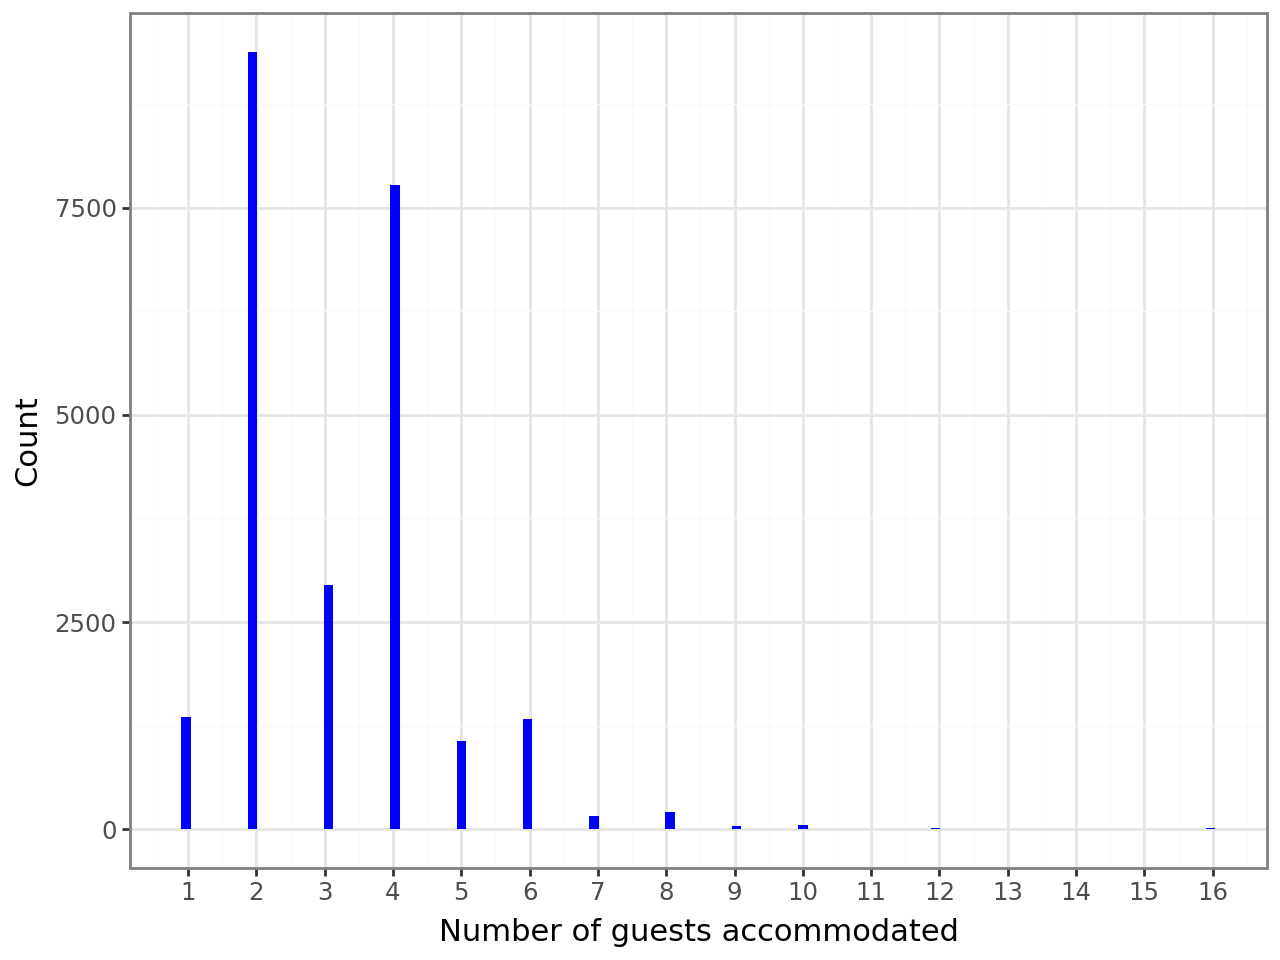

In [20]:
(
    ggplot(milanQ2, aes(x = 'accommodates'))
    + geom_histogram(color = None, fill = 'blue')
    + scale_x_continuous(breaks = range(0, 17, 1))
    + theme_bw()
    + labs(x = 'Number of guests accommodated', y = 'Count')
)

For the bathrooms, I will create categories rather than using the raw variable. First, I will assume that missing values actually do have a bathroom, so I will impute it with 1. Second, I will make categories of 0, 1, 2 and more than 2 bathrooms.

In [21]:
milanQ2.bathrooms.value_counts(dropna = False)

bathrooms
1.0     19488
2.0      2490
NaN      1238
1.5       569
3.0       212
2.5       114
0.5       100
0.0        65
4.0        34
3.5        17
5.0         7
6.0         5
4.5         3
7.0         2
5.5         1
21.0        1
Name: count, dtype: int64

For the bedrooms, I will simply impute the missing values with the median, that is 1.

In [22]:
milanQ2.bedrooms.value_counts(dropna = False)

bedrooms
1.0     17884
2.0      4039
0.0      1338
3.0       701
NaN       220
4.0       127
5.0        31
6.0         3
8.0         1
11.0        1
7.0         1
Name: count, dtype: int64

For the number of beds, I will impute based on the value of accomodates.

In [23]:
milanQ2.beds.value_counts(dropna = False)

beds
1.0     8766
2.0     7593
0.0     2984
3.0     2217
NaN     1316
4.0      926
5.0      285
6.0      154
7.0       51
8.0       28
9.0       10
10.0       5
12.0       4
14.0       3
11.0       2
17.0       1
18.0       1
Name: count, dtype: int64

The amenities column is a mess. The simplest approach I could do was to extract all possible amenities into seperate columns as dummies, and then filter for relatively common ones.

In [24]:
milanQ2.amenities.head()

id
6400      ["Washer", "Heating", "TV", "Hangers", "Wifi",...
304050    ["Washer", "Children\u2019s books and toys", "...
23986     ["Dedicated workspace", "Washer", "Heating", "...
309905    ["Children\u2019s books and toys", "Kitchen", ...
40470     ["Dedicated workspace", "Washer", "Exterior se...
Name: amenities, dtype: object

Listing where the price is not available will of course be dropped (around 5% of observations in total). I will later discuss whether we should also exclude some observations based on their extreme price values.

In [25]:
milanQ2.price.isna().sum()/milanQ2.shape[0]*100

5.056272077548673

The business case suggests that we are looking for operating a chain for short term rentals. Thus, I will exclude observations with minimum nights over a week (around 5%) to have similar observations in our sample to what we are interested in.

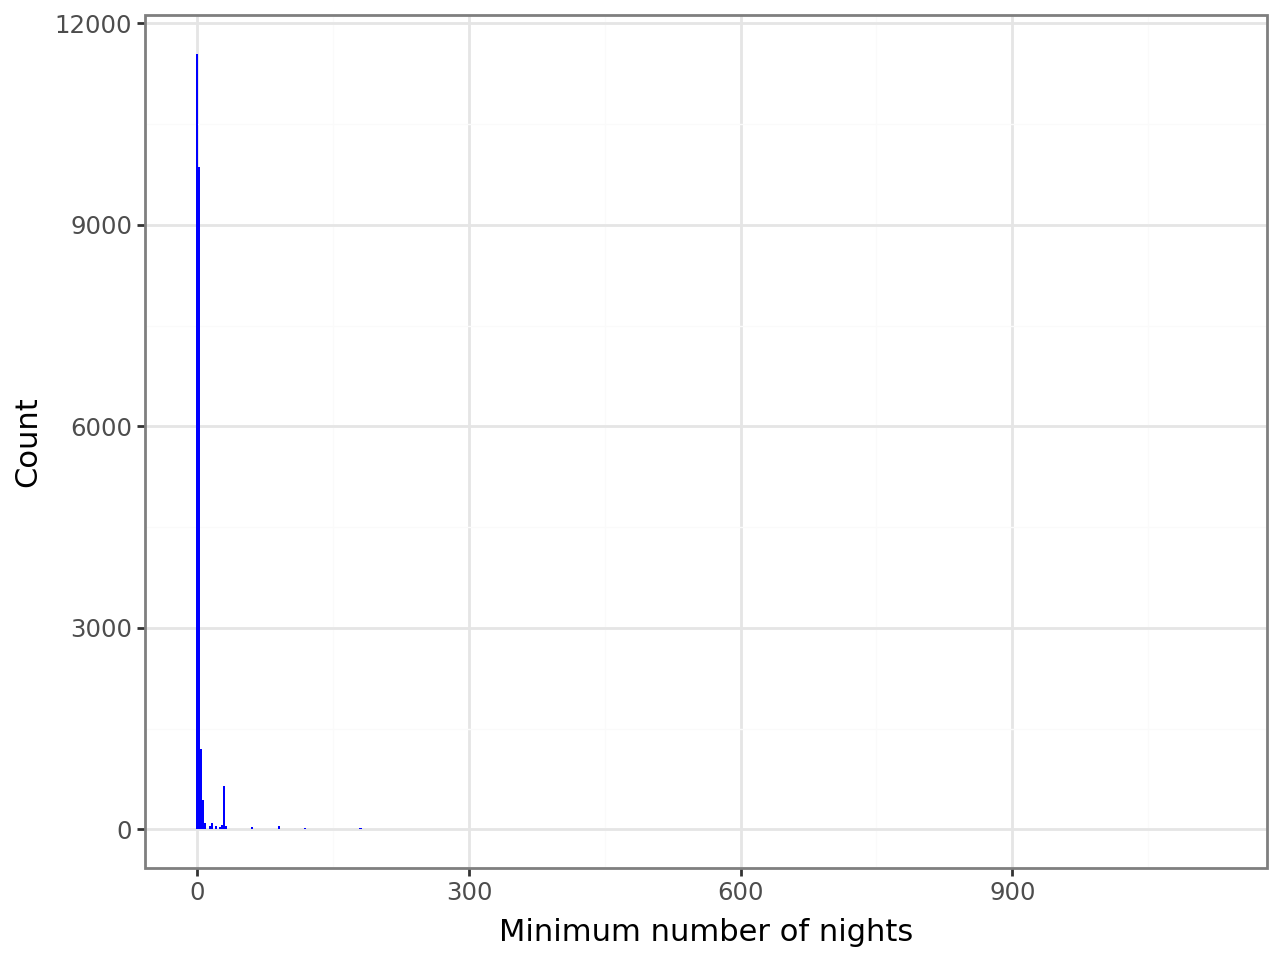

In [26]:
(
    ggplot(milanQ2, aes(x = 'minimum_nights'))
    + geom_histogram(bins = 500, color = None, fill = 'blue')
    + theme_bw()
    + labs(x = 'Minimum number of nights', y = 'Count')
)

Zooming in a bit and showing the proposed cutoff...

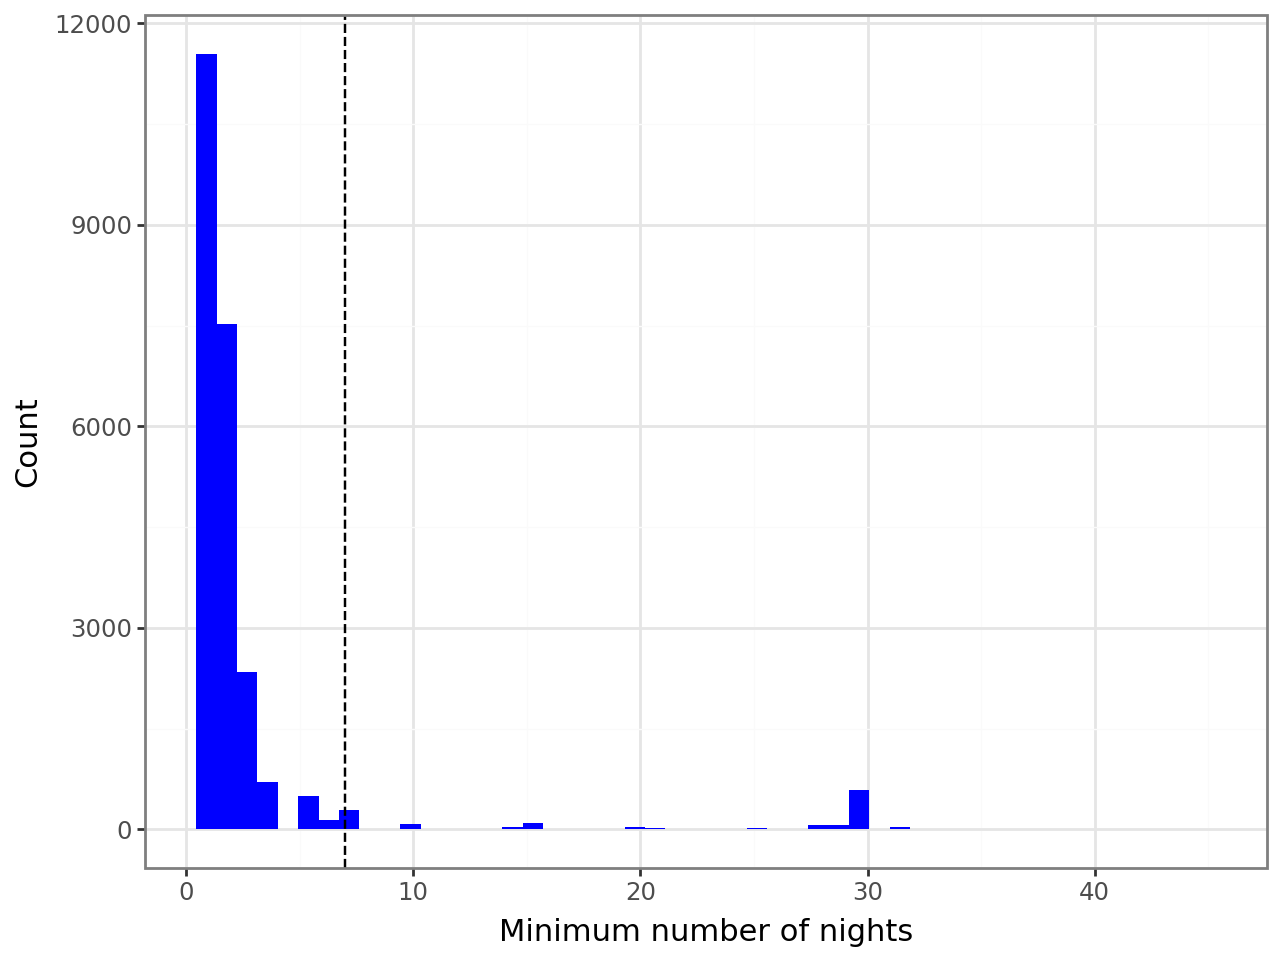

In [31]:
(
    ggplot(milanQ2[milanQ2['minimum_nights'] < 50], aes(x = 'minimum_nights'))
    + geom_histogram(bins = 50, color = None, fill = 'blue')
    + geom_vline(xintercept = 7, color = 'black', linetype = 'dashed')
    + theme_bw()
    + labs(x = 'Minimum number of nights', y = 'Count')
)

In [32]:
milanQ2[milanQ2['minimum_nights'] <= 7].shape[0] / milanQ2.shape[0] * 100

94.63156165283824

There is no point in keeping the number of reviews a continous variable given the very skewed distribution. I will instead make categories for 0, 1-10, 11-30 and 30+ reviews.

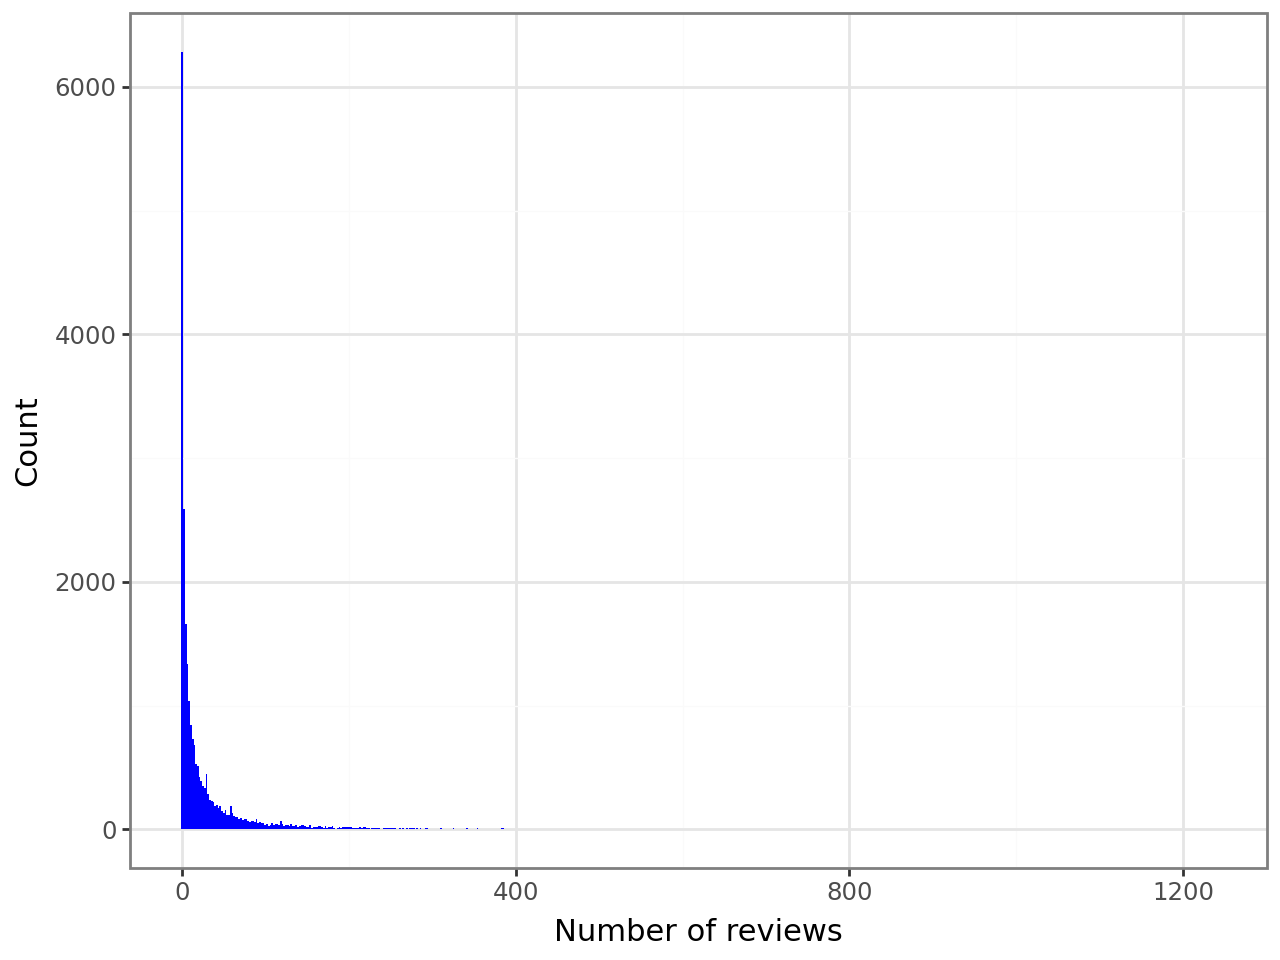

In [33]:
(
    ggplot(milanQ2, aes(x = 'number_of_reviews'))
    + geom_histogram(color = None, fill = 'blue')
    + theme_bw()
    + labs(x = 'Number of reviews', y = 'Count')
)

I will leave the ratings as is.

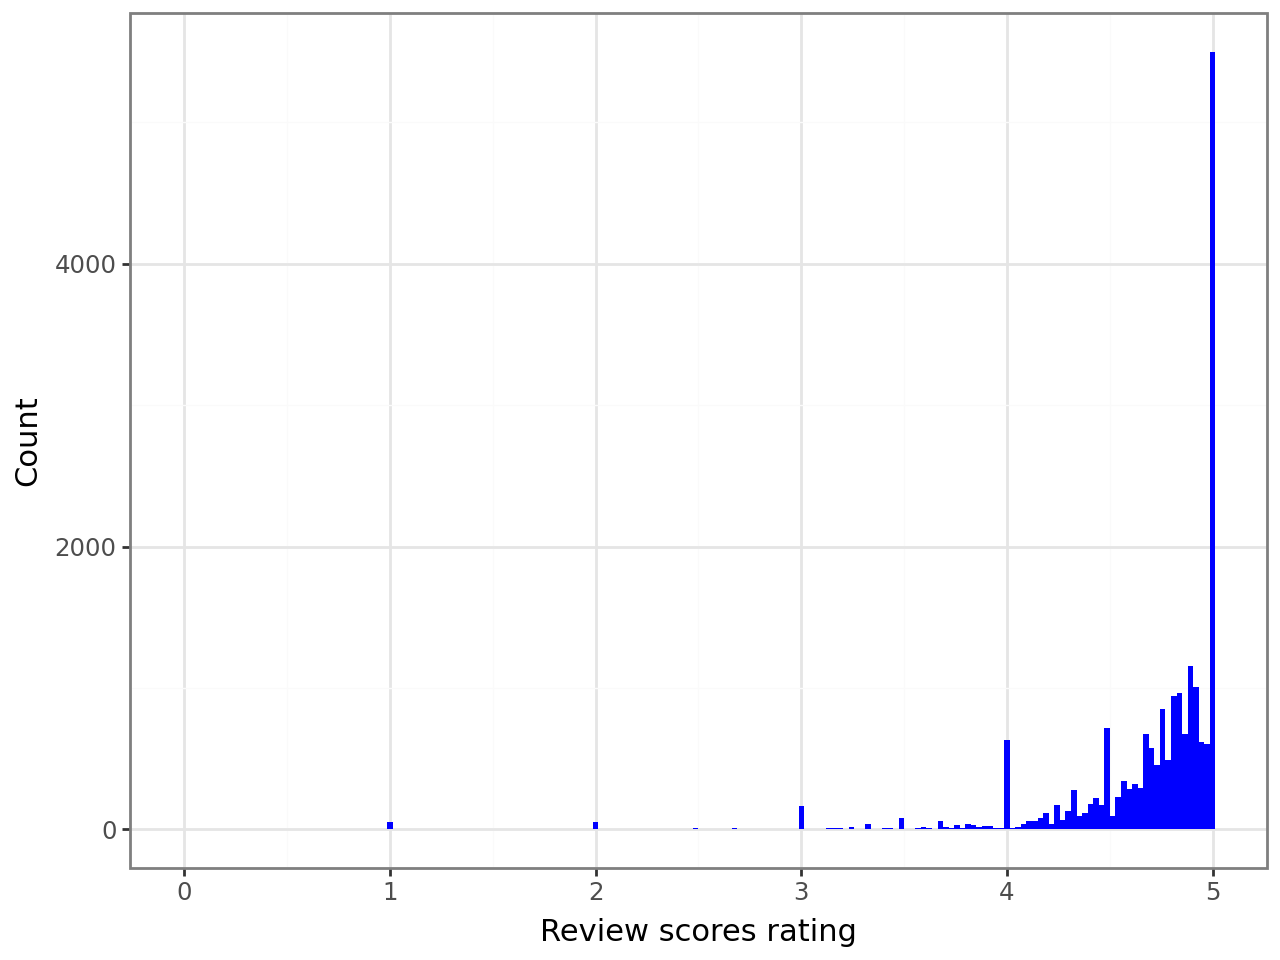

In [34]:
(
    ggplot(milanQ2, aes(x = 'review_scores_rating'))
    + geom_histogram(color = None, fill = 'blue')
    + theme_bw()
    + labs(x = 'Review scores rating', y = 'Count')
)

For the number of listings per host, let's look at some histograms.

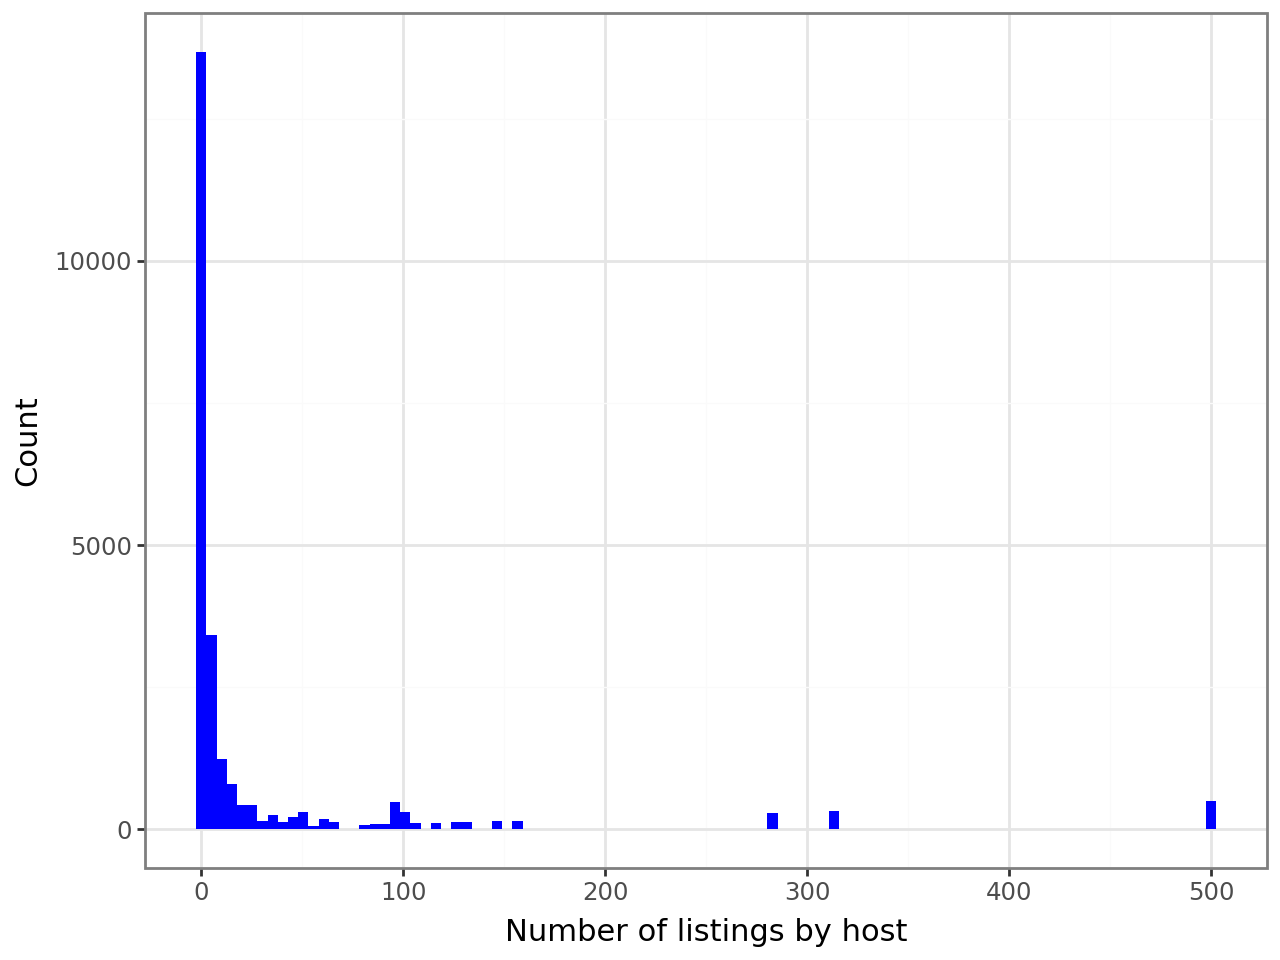

In [35]:
(
    ggplot(milanQ2, aes(x = 'calculated_host_listings_count'))
    + geom_histogram(bins = 100, color = None, fill = 'blue')
    + theme_bw()
    + labs(x = 'Number of listings by host', y = 'Count')
)

Zooming in...

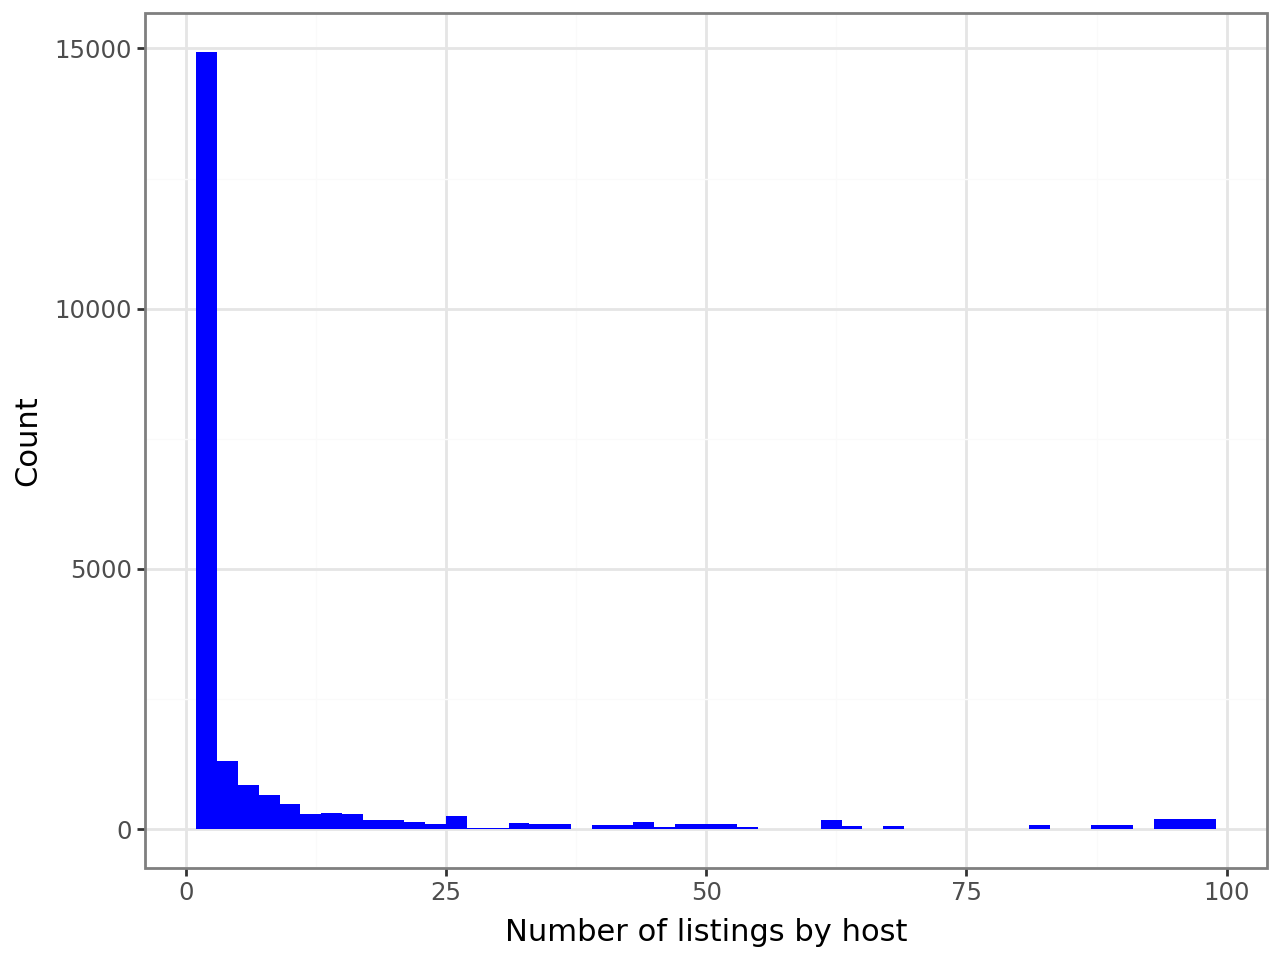

In [36]:
(
    ggplot(milanQ2[milanQ2['calculated_host_listings_count'] < 100], aes(x = 'calculated_host_listings_count'))
    + geom_histogram(bins = 50, color = None, fill = 'blue')
    + theme_bw()
    + labs(x = 'Number of listings by host', y = 'Count')
)

I will also keep the reviews per month as is.

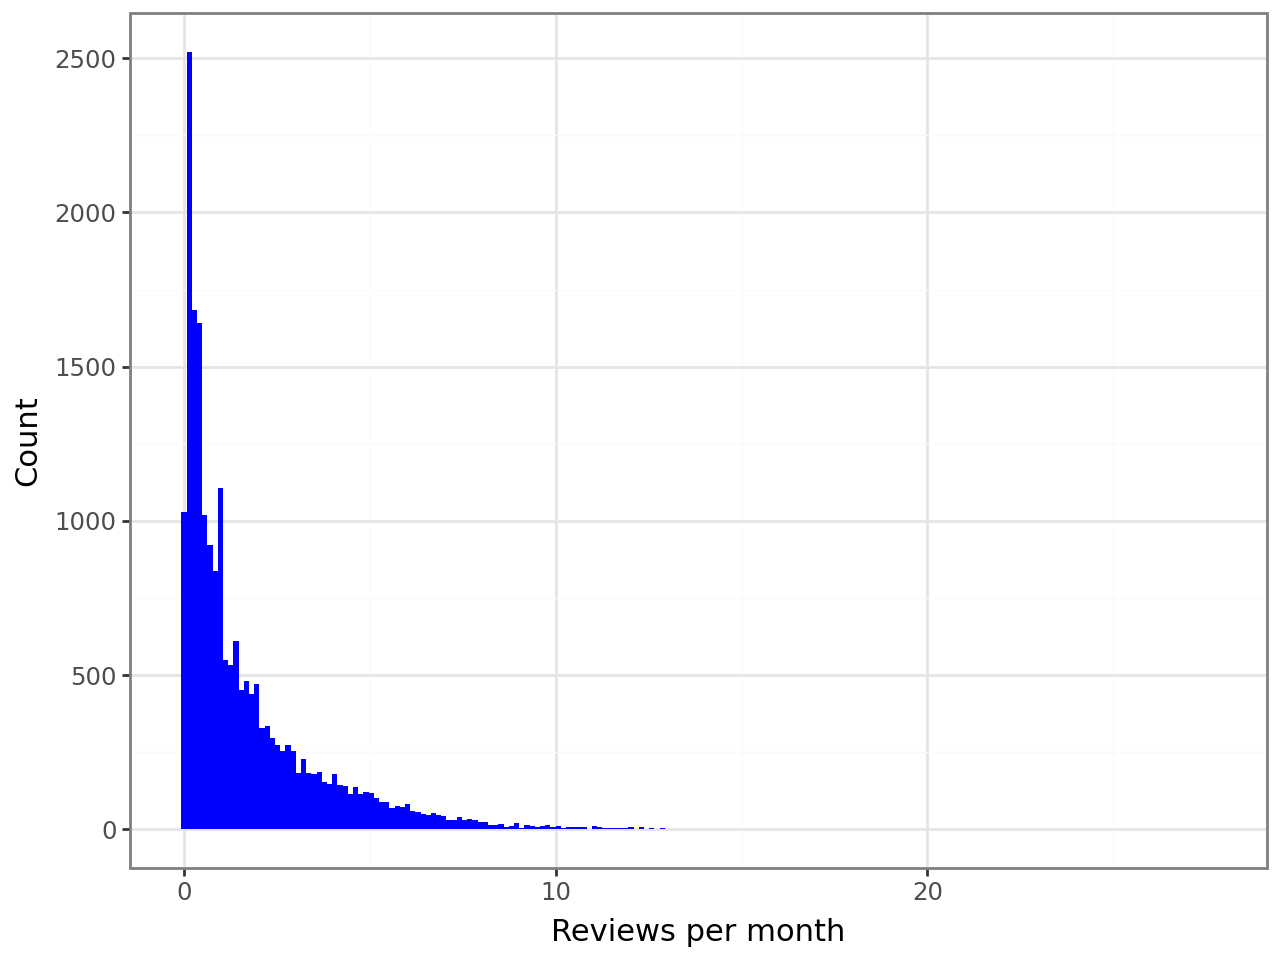

In [37]:
(
    ggplot(milanQ2, aes(x = 'reviews_per_month'))
    + geom_histogram(color = None, fill = 'blue')
    + theme_bw()
    + labs(x = 'Reviews per month', y = 'Count')
)

As we can see, most of the hosts have only 1 listing, some hosts has a few, while some have a lot. This can be simplified to a categorical variable with bins 1, 2-10 and 10+ listings.

In addition to the above variables, I will also calculate:
- the number of days a host is registered;
- the number of days since the first review.

For variables with a substantial amount of missing values, I will create flags for the missing values and impute with the median. These variables are:
- the review scores rating;
- the days since the first review;
- reviews per month.

In [38]:
def clean_df(df, center_lat, center_lon):
    df = df.copy() #not inplace

    # number of days the host is registered (no missing)
    df['n_host_since'] = (pd.to_datetime(df['last_scraped'], format = '%Y-%m-%d') - pd.to_datetime(df['host_since'], format = '%Y-%m-%d')).dt.days

    # host location Italy or Other, NAs imputed with missing category
    df['f_host_location'] = df['host_location'].apply(
        lambda x: 'Italy' if isinstance(x, str) and 'italy' in x.lower() else ('Missing' if pd.isna(x) else 'Other')).astype('category')

    # simple categorical, added Missing category for NAs
    df['f_host_response_time'] = df['host_response_time'].fillna('Missing').astype('category')

    # converted to numeric scale, imputed 0s for missing values (based on Ch16 case study code)
    df['p_host_response_rate'] = df.host_response_rate.fillna('0%').apply(lambda x: int(x.strip('%')))

    # converted to numeric scale, imputed 0s for missing values (based on Ch16 case study code)
    df['p_host_acceptance_rate'] = df.host_acceptance_rate.fillna('0%').apply(lambda x: int(x.strip('%')))

    # converted to binary, no missing
    df['d_host_is_superhost'] = df.host_is_superhost.apply(lambda x: 1 if x == 't' else 0)

    # added dummies for every possible host verification type (only three in practice)
    df = df.join(df['host_verifications'].apply(ast.literal_eval).apply(lambda x: pd.Series(1, index=x)).fillna(0).astype(int).add_prefix('d_hostverif_'))

    # converted to binary, no missing
    df['d_host_has_profile_pic'] = df.host_has_profile_pic.apply(lambda x: 1 if x == 't' else 0)

    # converted to binary, no missing
    df['d_host_identity_verified'] = df.host_identity_verified.apply(lambda x: 1 if x == 't' else 0)

    # I figured that I should not use neighbourhood data in my models, as in the case of Florence live data, I will have completely different values
    # So instead, I will use distance to center (calculated by me).
    #df['f_neighbourhood'] = df.neighbourhood_cleansed.astype('category')

    # Filtering to a sensible set of property types
    df = df.loc[lambda x: x['property_type'].isin(['Entire rental unit', 'Entire condo', 'Private room in rental unit', 'Private room in condo',
                                          'Entire loft', 'Entire home', 'Private room in loft', 'Private room in home'])]

    # Setting values to categories, no missing
    df['f_property_type'] = df.property_type.astype('category')

    # Setting values to categories, no missing
    df['f_room_type'] = df.room_type.astype('category')

    # Not interested in extremely big listings, filtering to max. 8 guests
    df = df[df['accommodates'] <= 8]
    df['n_accomodates'] = df.accommodates

    # Creating bathroom categories (0, 1, 2 and 2+)
    df['f_bathrooms'] = df.bathrooms.fillna(1).apply(lambda x: '0' if x < 1 else ('1' if (x >= 1 and x < 2) else ('2' if (x >= 2 and x < 3) else '2+'))).astype('category')

    # Imputing the number of bedrooms with the median
    df['n_bedrooms'] = df.bedrooms.fillna(np.median(df['bedrooms'].dropna()))

    # Imputing the number of beds with the number of possible guests
    df['n_beds'] = df.beds.fillna(df['accommodates'])

    # Adding a dummy for all possible amenities (will remove many later)
    df = df.join(df['amenities'].apply(lambda x: pd.Series(1, index=[amen.replace(' ', '_').replace('-', '_').lower() for amen in ast.literal_eval(x)])).add_prefix('d_amenities_').fillna(0).astype(int))

    # Dropping observations where no price (target), converting it to float
    df = df[df['price'].notna()]
    df['eur_price'] = df.price.apply(lambda x: x.replace('$', '').replace(',', '')).astype(float)

    # Interested in AirBnBs for short-term tourism: minimum nights should not be more than a week
    df = df[df['minimum_nights'] <= 7]

    # Categorizing the number of reviews: 0, 1-10, 11-30, 30+
    fnor = pd.cut(df['number_of_reviews'].to_list(),
       pd.IntervalIndex.from_tuples([(0, 1), (1, 11), (11, 31), (31, max(df.number_of_reviews)+1)], closed="left"),
       labels=['0', '1-10', '11-30', '30+'])
    fnor = fnor.rename_categories([0, 1, 2, 3])
    df['f_number_of_reviews'] = fnor

    # Calculating number of days since the first review
    df["n_days_since_first_rev"] = (
    df.last_scraped.apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
        - df.first_review.fillna("1950-01-01").apply(
            lambda x: datetime.strptime(x, "%Y-%m-%d")
        )).dt.days
    df["n_days_since_first_rev"] = np.where(df.first_review.isnull(), np.nan, df.n_days_since_first_rev)

    # adding prefix, will deal with missing later
    df['n_review_scores_rating'] = df.review_scores_rating

    # converting to binary, no missing
    df['d_instant_bookable'] = df.instant_bookable.apply(lambda x: 1 if x == 't' else 0)

    # Categorizing host listings count: 1, 2-10, 10+
    hlc = pd.cut(df['calculated_host_listings_count'].to_list(),
       pd.IntervalIndex.from_tuples([(0, 2), (2, 11), (11, max(df.calculated_host_listings_count)+1)], closed="left"),
       labels=['1', '2-10', '10+'])
    hlc = hlc.rename_categories([0, 1, 2])
    df['f_host_listings_count'] = hlc

    # Adding prefix, will deal with missing later
    df['n_reviews_per_month'] = df.reviews_per_month

    # calculating distance to city center
    df['n_distance_to_center'] = df.apply(lambda row: distance_to_center(row['latitude'], row['longitude'], center_lat, center_lon), axis=1)

    # filtering to columns with prefixes
    df = df.filter(regex="^d_.*|^n_.*|^f_.*|^p_.*|^eur_.*",)

    # creating flags for variables that had many missing values, and imputing with median
    df = df.assign(
        flag_n_days_since_first_rev = np.multiply(df.n_days_since_first_rev.isna(), 1),
        n_days_since_first_rev = df.n_days_since_first_rev.fillna(np.median(df.n_days_since_first_rev.dropna())),
        flag_n_review_scores_rating = np.multiply(df.n_review_scores_rating.isna(), 1),
        n_review_scores_rating = df.n_review_scores_rating.fillna(
            np.median(df.n_review_scores_rating.dropna())
        ),
        flag_n_reviews_per_month = np.multiply(df.n_reviews_per_month.isna(), 1),
        n_reviews_per_month = df.n_reviews_per_month.fillna(
            np.median(df.n_reviews_per_month.dropna())
        )
    )

    return df

For calculating the distance to center, I manually looked up the city center coordinates for both cities.

In [39]:
milan_lat = 45.464664
milan_lon = 9.188540
florence_lat = 43.769562
florence_lon  = 11.255814

Applying the cleaning function to MilanQ2.

In [40]:
milanQ2 = clean_df(milanQ2, milan_lat, milan_lon)

As there were a couple thousand different amenities in the dataset, I decided to only keep those, that were present at at least a quarter of the observations.

In [41]:
# keep only such amenities in our source data that are present at at least 25% of the listings
milanQ2.drop([col for col in milanQ2.columns if ('d_amenities' in col and milanQ2[col].sum() < milanQ2.shape[0]*0.25)], inplace = True, axis = 1)

Note that I apply the cleaning function here (that is actually task 5 in the assignment description). The reason for this is that I only want to have such amenities in my training data that are also present in the 'live' data as well.

In [42]:
milanQ3 = clean_df(milanQ3, milan_lat, milan_lon)

In [43]:
florenceQ2 = clean_df(florenceQ2, florence_lat, florence_lon)

In [44]:
# filter out such host_verifs and amenities that are not present in all tables
# the other cols are common as we have created them
milanQ2.drop([col for col in milanQ2 if col not in set(milanQ2.columns).intersection(set(milanQ3.columns)).intersection(set(florenceQ2))], inplace = True, axis = 1)
milanQ3.drop([col for col in milanQ3 if col not in set(milanQ2.columns).intersection(set(milanQ3.columns)).intersection(set(florenceQ2))], inplace = True, axis = 1)
florenceQ2.drop([col for col in florenceQ2 if col not in set(milanQ2.columns).intersection(set(milanQ3.columns)).intersection(set(florenceQ2))], inplace = True, axis = 1)

I also add squared and cubed polynomials to my datasets.

In [45]:
def add_poly_vars(df):
    df = df.copy()
    numeric_cols = [col for col in df if col[0:2] == 'n_']
    for c in numeric_cols:
        df[f'sq_{c}'] = np.power(df[c], 2)
        df[f'cu_{c}'] = np.power(df[c], 3)
    return df

In [46]:
milanQ2 = add_poly_vars(milanQ2)
milanQ3 = add_poly_vars(milanQ3)
florenceQ2 = add_poly_vars(florenceQ2)

All in all, I am left with 20,730 observations in my MilanQ2 dataset (out of the initial 24,346).

In [47]:
milanQ2[[col for col in milanQ2 if col[0:2] == 'n_' or col[0:5] in ['sq_n_', 'cu_n_']]].describe().T

count          mean           std        min  \
n_host_since               20730.0  2.541313e+03  1.336679e+03   3.000000   
n_accomodates              20730.0  3.224940e+00  1.367177e+00   1.000000   
n_bedrooms                 20730.0  1.178244e+00  5.803805e-01   0.000000   
n_beds                     20730.0  1.603232e+00  1.122176e+00   0.000000   
n_days_since_first_rev     20730.0  8.645611e+02  9.675938e+02   0.000000   
n_review_scores_rating     20730.0  4.731977e+00  3.873992e-01   0.000000   
n_reviews_per_month        20730.0  1.690186e+00  1.907503e+00   0.010000   
n_distance_to_center       20730.0  3.003237e+00  1.529555e+00   0.037974   
sq_n_host_since            20730.0  8.244899e+06  6.215877e+06   9.000000   
cu_n_host_since            20730.0  2.899298e+10  2.714777e+10  27.000000   
sq_n_accomodates           20730.0  1.226932e+01  1.053576e+01   1.000000   
cu_n_accomodates           20730.0  5.354071e+01  7.278772e+01   1.000000   
sq_n_bedrooms              20730.0  1.725084e+00  1.908545e+00   0.000000   
cu_n_bedrooms              20730.0  3.069706e+00  6.223987e+00   0.000000   
sq_n_beds                  20730.0  3.829571e+00  5.963696e+00   0.000000   
cu_n_beds                  20730.0  1.193087e+01  5.162665e+01   0.000000   
sq_n_days_since_first_rev  20730.0  1.683659e+06  3.369521e+06   0.000000   
cu_n_days_since_first_rev  20730.0  4.574518e+09  1.197852e+10   0.000000   
sq_n_review_scores_rating  20730.0  2.254168e+01  3.103501e+00   0.000000   
cu_n_review_scores_rating  20730.0  1.078528e+02  1.981526e+01   0.000000   
sq_n_reviews_per_month     20730.0  6.495118e+00  1.696692e+01   0.000100   
cu_n_reviews_per_month     20730.0  3.969365e+01  2.238746e+02   0.000001   
sq_n_distance_to_center    20730.0  1.135885e+01  1.139739e+01   0.001442   
cu_n_distance_to_center    20730.0  5.080430e+01  7.972899e+01   0.000055   

                                    25%           50%           75%  \
n_host_since               1.438000e+03  2.930000e+03  3.606000e+03   
n_accomodates              2.000000e+00  3.000000e+00  4.000000e+00   
n_bedrooms                 1.000000e+00  1.000000e+00  1.000000e+00   
n_beds                     1.000000e+00  1.000000e+00  2.000000e+00   
n_days_since_first_rev     2.510000e+02  4.800000e+02  9.890000e+02   
n_review_scores_rating     4.670000e+00  4.840000e+00  4.960000e+00   
n_reviews_per_month        4.700000e-01  1.010000e+00  2.140000e+00   
n_distance_to_center       1.885192e+00  2.823209e+00  3.841611e+00   
sq_n_host_since            2.067844e+06  8.584900e+06  1.300324e+07   
cu_n_host_since            2.973560e+09  2.515376e+10  4.688967e+10   
sq_n_accomodates           4.000000e+00  9.000000e+00  1.600000e+01   
cu_n_accomodates           8.000000e+00  2.700000e+01  6.400000e+01   
sq_n_bedrooms              1.000000e+00  1.000000e+00  1.000000e+00   
cu_n_bedrooms              1.000000e+00  1.000000e+00  1.000000e+00   
sq_n_beds                  1.000000e+00  1.000000e+00  4.000000e+00   
cu_n_beds                  1.000000e+00  1.000000e+00  8.000000e+00   
sq_n_days_since_first_rev  6.300100e+04  2.304000e+05  9.781210e+05   
cu_n_days_since_first_rev  1.581325e+07  1.105920e+08  9.673617e+08   
sq_n_review_scores_rating  2.180890e+01  2.342560e+01  2.460160e+01   
cu_n_review_scores_rating  1.018476e+02  1.133799e+02  1.220239e+02   
sq_n_reviews_per_month     2.209000e-01  1.020100e+00  4.579600e+00   
cu_n_reviews_per_month     1.038230e-01  1.030301e+00  9.800344e+00   
sq_n_distance_to_center    3.553949e+00  7.970510e+00  1.475797e+01   
cu_n_distance_to_center    6.699876e+00  2.250242e+01  5.669439e+01   

                                    max  
n_host_since               5.576000e+03  
n_accomodates              8.000000e+00  
n_bedrooms                 5.000000e+00  
n_beds                     1.700000e+01  
n_days_since_first_rev     5.178000e+03  
n_review_scores_rating     5.000000e+00  
n_reviews_per_month        2.7690

If we look at the price distribution, we can see that there are some extremely large values. I believe these are not quite relevant for our business case if we assume that we do not want to operate a high-end AirBnB chain.

In [48]:
milanQ2.eur_price.describe(percentiles=[0.01,0.05,0.25, 0.5, 0.75, 0.95, 0.96, 0.97, 0.98, 0.99, 0.995, 0.999])

count    20730.000000
mean       179.544621
std        967.429763
min         12.000000
1%          42.000000
5%          56.000000
25%         83.000000
50%        110.000000
75%        163.000000
95%        394.000000
96%        433.840000
97%        500.000000
98%        668.840000
99%       1000.000000
99.5%     1461.420000
99.9%     8708.400000
max      90000.000000
Name: eur_price, dtype: float64

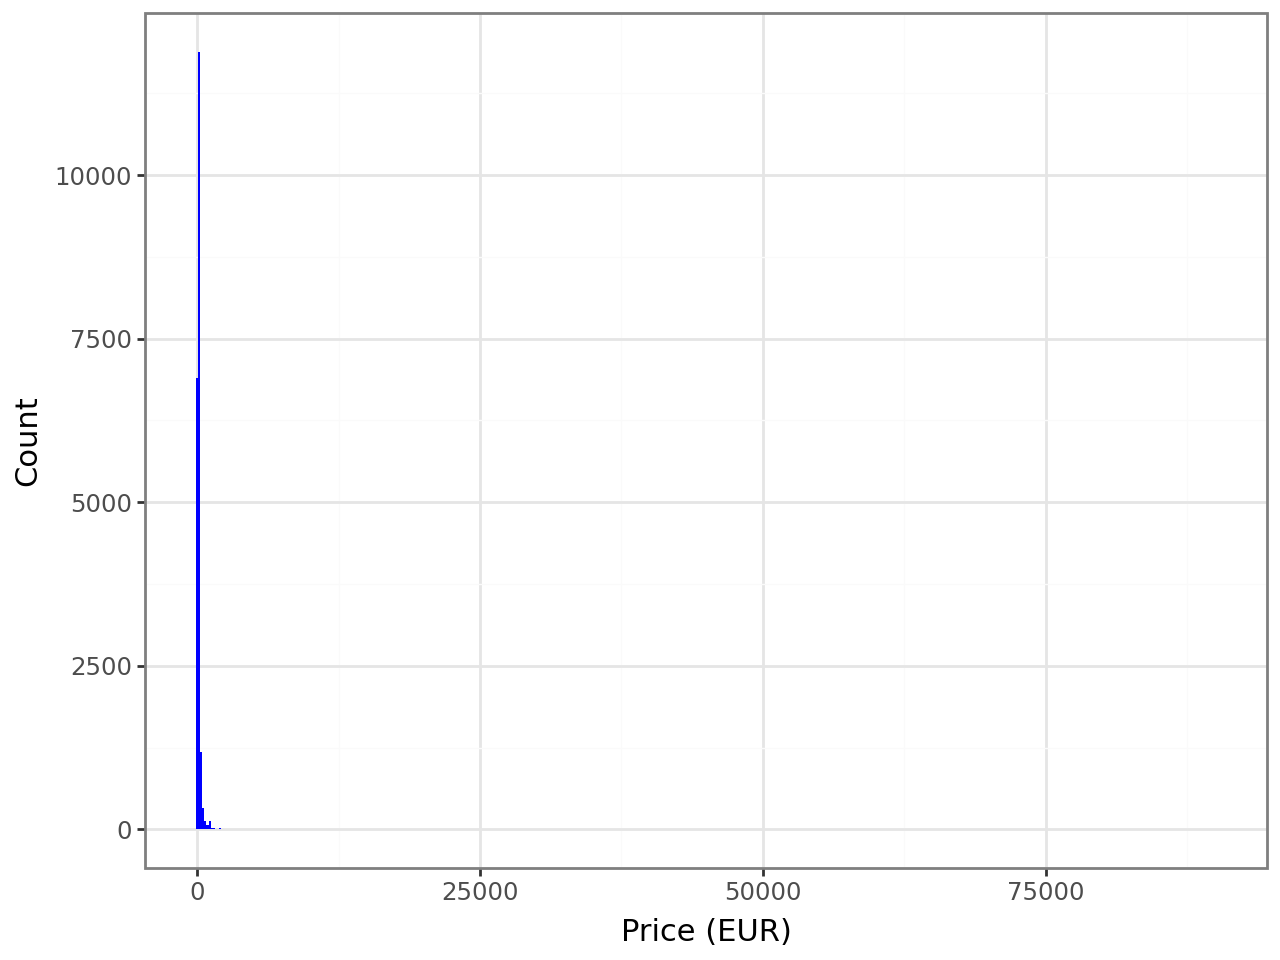

In [49]:
(
    ggplot(milanQ2, aes(x = 'eur_price'))
    + geom_histogram(bins = 500, color = None, fill = 'blue')
    + theme_bw()
    + labs(x = 'Price (EUR)', y = 'Count')
)

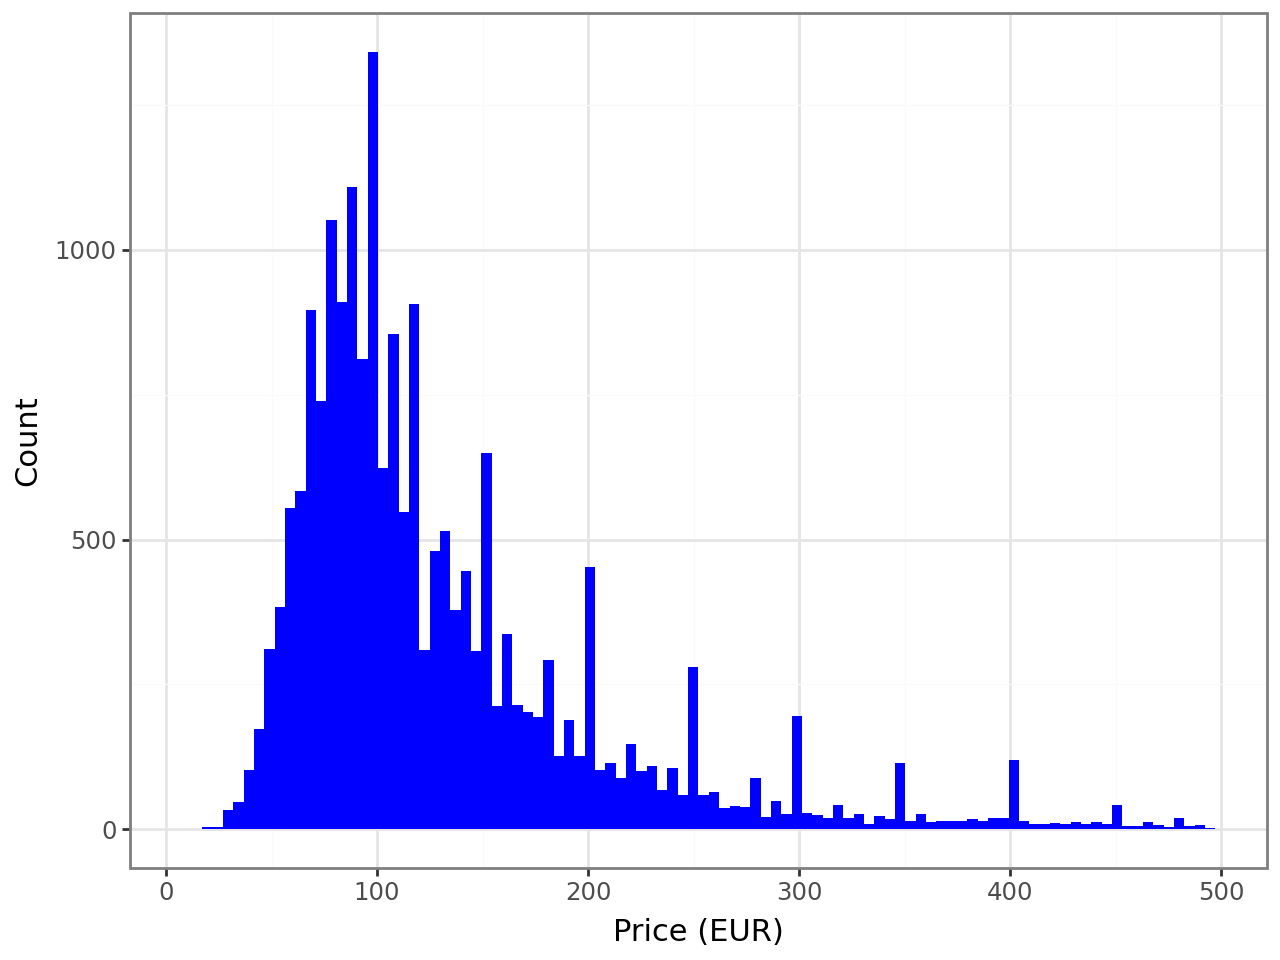

In [50]:
(
    ggplot(milanQ2[milanQ2['eur_price'] < 500], aes(x = 'eur_price'))
    + geom_histogram(bins = 100, color = None, fill = 'blue')
    + theme_bw()
    + labs(x = 'Price (EUR)', y = 'Count')
)

In [51]:
# prices above 500 EUR are simply too extreme to predict
milanQ2 = milanQ2[milanQ2['eur_price'] <= 500]

I apply a 70%-30% train vs. hold-out split. This means a 14K observation training sample.

In [52]:
data_train, data_holdout = train_test_split(milanQ2, train_size=0.7, random_state=42)

### 1.2. Building predictive models

With the clean dataset at hand, we can now begin building models. I will build five predictive models:

1. simple OLS (trying different specifications with 5-fold cross-validation);
2. LASSO (starting from the most complex OLS specification);
3. Random Forest (with moderate tuning);
4. GBM (with minimal tuning);
5. XGBoost (with moderate tuning).

Note that the level of tuning for the last three models is mainly determined by the computational limitations of my computer.

First, I group my variables into certain categories to be able to easily construct variable sets.

In [53]:
basic_vars = ('f_property_type', 'f_room_type', 'n_accomodates', 'f_bathrooms', 'n_bedrooms', 'n_beds', 'n_distance_to_center', 'd_instant_bookable')
host_vars = ('n_host_since', 'f_host_location', 'f_host_response_time', 'p_host_response_rate', 'p_host_acceptance_rate', 'd_host_is_superhost',
             'd_hostverif_email', 'd_hostverif_phone', 'd_hostverif_work_email', 'd_host_has_profile_pic', 'd_host_identity_verified',
             'f_host_listings_count')
review_vars = ('f_number_of_reviews', 'n_days_since_first_rev', 'n_review_scores_rating', 'n_reviews_per_month', 'flag_n_days_since_first_rev',
              'flag_n_review_scores_rating', 'flag_n_reviews_per_month')
amenities = tuple([col for col in data_train if 'd_amenities_' in col])
poly_vars = tuple([col for col in data_train if col[0:2] in ['sq', 'cu']])

The below variables will be used to train RF, GBM and XGBoost models (thus no polynomials or interactions are specified).

In [54]:
predictors_ml = basic_vars + host_vars + review_vars + amenities

For the OLS models, I wanted to uncover some possible interaction terms. For this, I used a graphical approach. In code comments, I indicated whether I have deemed the graphical evidence strong enough to include a certain interaction term.

Note that I have tweaked the pre-written utility function a bit so that it can also be used to visualize factor-factor interactions.

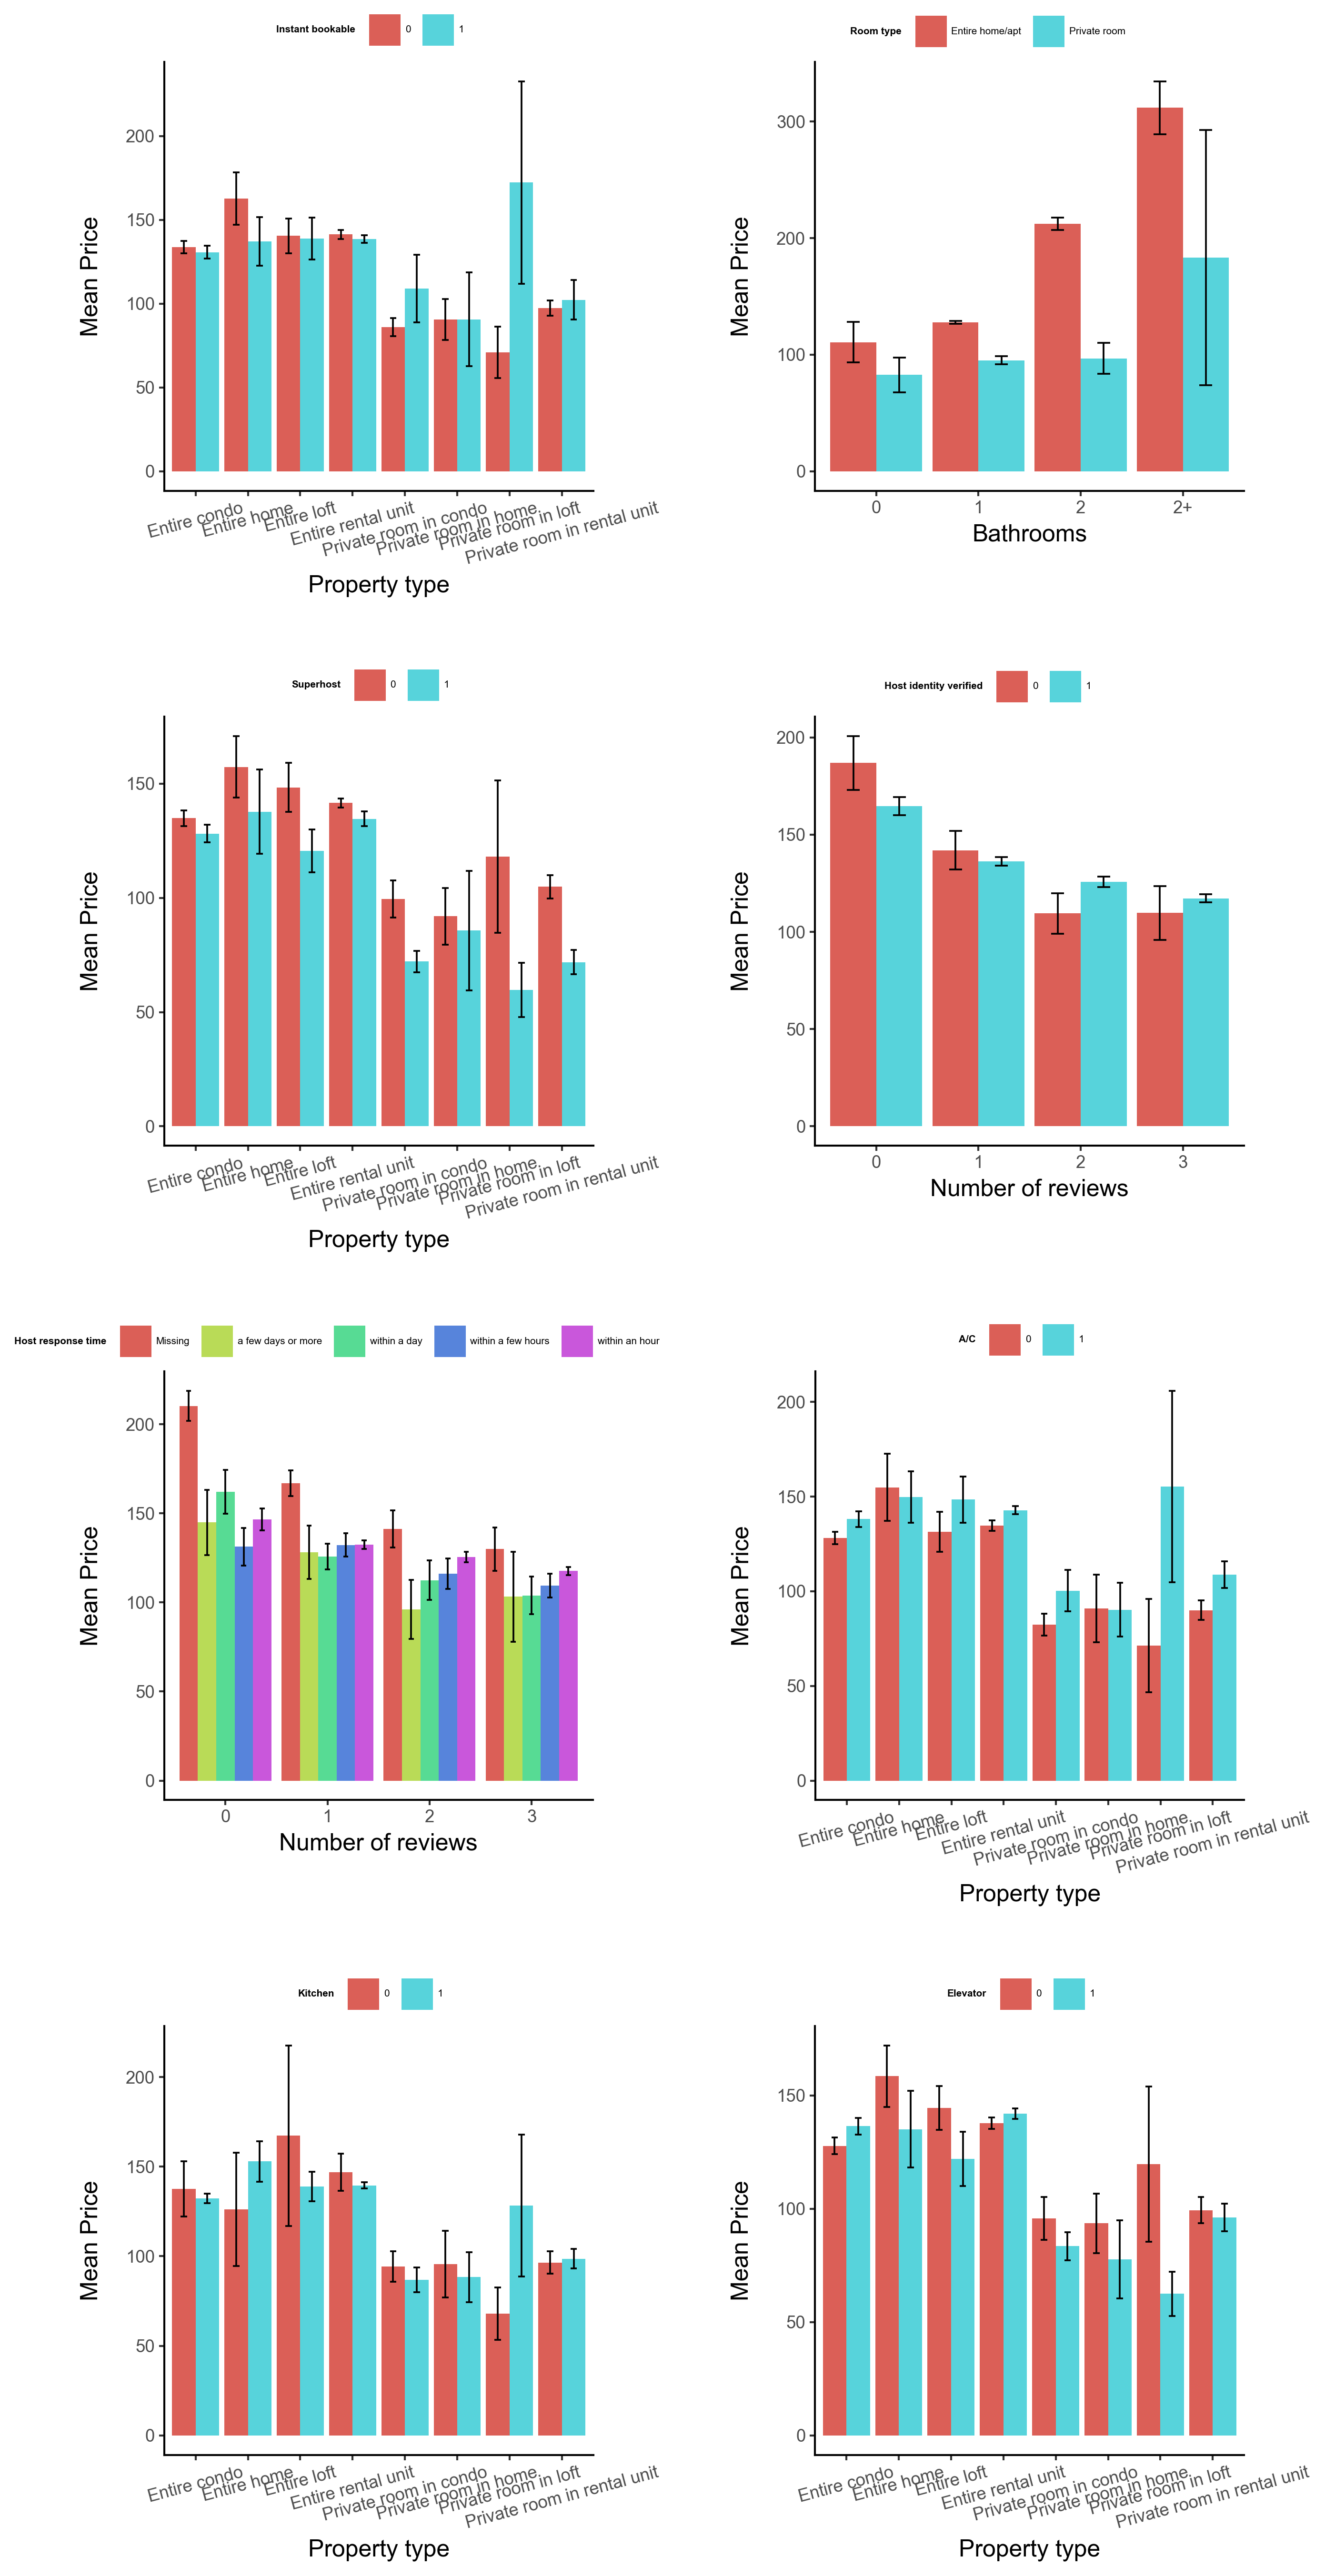

In [58]:
# interaction
p1 = price_diff_by_variables(data_train.rename(columns={'eur_price': 'price'}), 'f_property_type', 'd_instant_bookable',
                        'Property type', 'Instant bookable') + theme(axis_text_x=element_text(angle = 15))

# no interaction
p2 = price_diff_by_variables(data_train.rename(columns={'eur_price': 'price'}), 'f_bathrooms', 'f_room_type',
                        'Bathrooms', 'Room type')

# no interaction
p3 = price_diff_by_variables(data_train.rename(columns={'eur_price': 'price'}), 'f_property_type', 'd_host_is_superhost',
                        'Property type', 'Superhost') + theme(axis_text_x=element_text(angle = 15))

# no interaction
p4 = price_diff_by_variables(data_train.rename(columns={'eur_price': 'price'}), 'f_number_of_reviews', 'd_host_identity_verified',
                        'Number of reviews', 'Host identity verified')

# interaction
p5 = price_diff_by_variables(data_train.rename(columns={'eur_price': 'price'}), 'f_number_of_reviews', 'f_host_response_time',
                        'Number of reviews', 'Host response time')

# interaction
p6 = price_diff_by_variables(data_train.rename(columns={'eur_price': 'price'}), 'f_property_type', 'd_amenities_air_conditioning',
                        'Property type', 'A/C') + theme(axis_text_x=element_text(angle = 15))

# interaction
p7 = price_diff_by_variables(data_train.rename(columns={'eur_price': 'price'}), 'f_property_type', 'd_amenities_kitchen',
                        'Property type', 'Kitchen') + theme(axis_text_x=element_text(angle = 15))

# no interaction
p8 = price_diff_by_variables(data_train.rename(columns={'eur_price': 'price'}), 'f_property_type', 'd_amenities_elevator',
                        'Property type', 'Elevator') + theme(axis_text_x=element_text(angle = 15))

g1 = pw.load_ggplot(p1, figsize=(3, 3))
g2 = pw.load_ggplot(p2, figsize=(3, 3))
g3 = pw.load_ggplot(p3, figsize=(3, 3))
g4 = pw.load_ggplot(p4, figsize=(3, 3))
g5 = pw.load_ggplot(p5, figsize=(3, 3))
g6 = pw.load_ggplot(p6, figsize=(3, 3))
g7 = pw.load_ggplot(p7, figsize=(3, 3))
g8 = pw.load_ggplot(p8, figsize=(3, 3))

interactions = (g1 | g2) / (g3 | g4 ) / (g5 | g6) / (g7 | g8)

display(interactions)

Having some interaction terms, we can now construct some OLS model equations in increasing complexity.

In [59]:
interaction_vars = ('f_property_type*d_instant_bookable', 'f_number_of_reviews*f_host_response_time',
                   'f_property_type*d_amenities_air_conditioning', 'f_property_type*d_amenities_kitchen')

In [60]:
ols_equations = [
    "~" + " + ".join(basic_vars),
    "~" + " + ".join(basic_vars + host_vars + review_vars),
    "~" + " + ".join(basic_vars + host_vars + review_vars + poly_vars),
    "~" + " + ".join(basic_vars + host_vars + review_vars + poly_vars + amenities),
    "~" + " + ".join(basic_vars + host_vars + review_vars + poly_vars + amenities + interaction_vars),
    ("~" + " + ".join(basic_vars + host_vars + review_vars + poly_vars + amenities + interaction_vars) 
     + " + " + "(f_property_type + f_room_type + f_number_of_reviews) * (" + "+".join(amenities) + ")")
]

In [24]:
with open("model_times.json", "r", encoding="utf-8") as f:
    model_times = json.load(f)

# NOTE: Running the model estimations takes a considerable amount of time. I recommend using only the pre-estimated results from the dill files (indicated in a further note).

The best OLS model is found through 5-fold cross-validation.

In [89]:
start_time = time()
cv_list = []
for model in ols_equations:
    cv_list += [ols_crossvalidator("eur_price" + model, data_train, 5, rstate = 1234)]
model_times = {
    'ols' : time() - start_time
}

Technically, the best model (by test RMSE) would be M5 - but instead, I have decided to work further with M4 instead, as its test RMSE is practically the same, but it is less complex.

In [91]:
compare_model_fits = (
    pd.DataFrame(cv_list)
    .round(2)
    .assign(
        Model=["M" + str(i + 1) for i in range(len(cv_list))],
        BIC=lambda x: x["BIC"].astype(int),
        Coefficients=lambda x: x["Coefficients"].astype(int),
    )
    .filter(["Model", "Coefficients", "R-squared", "BIC", "Training RMSE", "Test RMSE"])
)
compare_model_fits

Model  Coefficients  R-squared     BIC  Training RMSE  Test RMSE
0    M1            16       0.26  159462          68.76      68.85
1    M2            39       0.36  157591          63.83      64.07
2    M3            55       0.40  156897          61.92      62.32
3    M4            98       0.41  156955          61.13      61.77
4    M5           131       0.42  157063          60.67      61.45
5    M6           531       0.45  160211          59.05      62.34

Finally, I re-fitted the best model on the whole train sample.

In [93]:
y, X = dmatrices("eur_price" + ols_equations[3], data_train)
ols_model = LinearRegression().fit(X, y)

I also save into dill files my models, and the timing estimate to a JSON.

In [95]:
with open("model_times.json", "w") as f:
    json.dump(model_times, f)
with open(Path("model_dills", "ols_model_cv.dill"), "wb") as f:
    dill.dump(cv_list, f)
with open(Path("model_dills", "ols_model.dill"), "wb") as f:
    dill.dump(ols_model, f)

Next, I fit a LASSO model, starting from the most complex equation (M6). I find the tuning parameter through cross-validation. Note that for proper results, I have to standardize my predictors. I will use the same scaler to standardize the hold-out and the live-data as well.

In [37]:
lasso_model = ElasticNet(l1_ratio=1, fit_intercept=True, random_state= 9876)
lasso_model_cv = GridSearchCV(
    lasso_model,
    {"alpha": [i / 100 for i in range(0, 100, 5)]},
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=0,
)
y, X = dmatrices("eur_price" + ols_equations[5], data_train)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
start_time = time()
lasso_model_cv.fit(X_scaled, y.ravel())
model_times['lasso'] = time() - start_time

I then save my results.

In [38]:
with open("model_times.json", "w") as f:
    json.dump(model_times, f)
with open(Path("model_dills", "lasso_model.dill"), "wb") as f:
    dill.dump(lasso_model_cv.best_estimator_, f)
with open(Path("model_dills", "lasso_model_cv.dill"), "wb") as f:
    dill.dump(lasso_model_cv, f)

The next model is a Random Forest. I set n-estimators to 250, and include moderate tuning. As the number of input features is 86, the theoretically optimal number of maximum features is the square root of this, that is around 9. So I build the tuning grid around this intuition.

In [103]:
rfr = RandomForestRegressor(
    random_state=485,
    criterion="squared_error",
    n_estimators=250,
    oob_score=True,
    n_jobs=7,
)

tune_grid = {"max_features": [8, 10, 12, 14, 16], "min_samples_split": [3, 5, 10, 15]}

rf_random = GridSearchCV(
    rfr, tune_grid, cv=5, scoring="neg_root_mean_squared_error", verbose=0
)

y, X = dmatrices("eur_price ~ " + " + ".join(predictors_ml), data_train)

start_time = time()
rf_model_cv = rf_random.fit(X, y.ravel())
model_times['rf'] = time() - start_time

The results are then saved.

In [105]:
with open("model_times.json", "w") as f:
    json.dump(model_times, f)
with open(Path("model_dills", "rf_model.dill"), "wb") as f:
    dill.dump(rf_model_cv.best_estimator_, f)
with open(Path("model_dills", "rf_model_cv.dill"), "wb") as f:
    dill.dump(rf_model_cv, f)

The first boosting model is a GBM one. I could only provide very simple tuning to avoid computational issues.

In [108]:
gbm = GradientBoostingRegressor(learning_rate=0.1, min_samples_split=20, random_state = 31)

tune_grid = {"n_estimators": [i for i in range(200, 500, 50)], "max_depth": [1, 5, 10]}

gbm_model_cv = GridSearchCV(
    gbm, tune_grid, cv=5, scoring="neg_root_mean_squared_error", verbose=0, n_jobs=-1
)

categorical_columns = [col for col in predictors_ml if col.startswith("f_")]
numerical_columns = [col for col in predictors_ml if col not in categorical_columns]

categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", "passthrough", numerical_columns),
    ]
)

gbm_pipe = Pipeline(
    [("preprocess", preprocessing), ("regressor", gbm_model_cv)], verbose = False
)

start_time = time()
gbm_pipe.fit(data_train[list(predictors_ml)], data_train.eur_price)
timespan = time() - start_time
model_times['gbm'] = timespan

I again save the results.

In [117]:
with open("model_times.json", "w") as f:
    json.dump(model_times, f)
with open(Path("model_dills", "gbm_model.dill"), "wb") as f:
    dill.dump(gbm_model_cv.best_estimator_, f)
with open(Path("model_dills", "gbm_model_cv.dill"), "wb") as f:
    dill.dump(gbm_model_cv, f)

The final model is an XGBoost regression with moderate tuning.

In [25]:
xgb = XGBRegressor(
    tree_method="hist", 
    objective="reg:squarederror",
    random_state = 56
)

tune_grid = {
    "n_estimators": [250, 350, 450],  
    "max_depth": [3, 6, 9],  
    "colsample_bytree": [0.6, 0.8, 1.0],   
    "learning_rate": [0.05, 0.1],
    "min_child_weight": [10, 20]
}

xgb_model_cv = GridSearchCV(
    xgb, tune_grid, cv=5, scoring="neg_root_mean_squared_error", verbose=0, n_jobs=-1
)

categorical_columns = [col for col in predictors_ml if col.startswith("f_")]
numerical_columns = [col for col in predictors_ml if col not in categorical_columns]

categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", "passthrough", numerical_columns),
    ]
)

xgb_pipe = Pipeline(
    [("preprocess", preprocessing), ("regressor", xgb_model_cv)], verbose = False
)

start_time = time()
xgb_pipe.fit(data_train[list(predictors_ml)], data_train.eur_price)
timespan = time() - start_time
model_times['xgb'] = timespan

I save these results as well.

In [27]:
with open("model_times.json", "w") as f:
    json.dump(model_times, f)
with open(Path("model_dills", "xgb_model.dill"), "wb") as f:
    dill.dump(xgb_model_cv.best_estimator_, f)
with open(Path("model_dills", "xgb_model_cv.dill"), "wb") as f:
    dill.dump(xgb_model_cv, f)

Add files to an archive so that they can be pushed to GitHub.

In [39]:
files_to_zip = [Path("model_dills", "ols_model_cv.dill"), Path("model_dills", "ols_model.dill"),
               Path("model_dills", "lasso_model.dill"), Path("model_dills", "lasso_model_cv.dill"),
               Path("model_dills", "rf_model.dill"), Path("model_dills", "rf_model_cv.dill"),
               Path("model_dills", "gbm_model.dill"), Path("model_dills", "gbm_model_cv.dill"),
               Path("model_dills", "xgb_model.dill"), Path("model_dills", "xgb_model_cv.dill")]

zip_filename = 'model_dills.zip'

with zipfile.ZipFile(zip_filename, 'w', compression=zipfile.ZIP_DEFLATED, compresslevel=9) as zipf:
    for file in files_to_zip:
        zipf.write(file, arcname=file.name)

# Note: Running the code from here, you only import the pre-estimated models stored in dill files.
### 1.3. Model comparison and discussion

First, we have to load the saved models from the dill files.

In [61]:
with open("model_times.json", "r", encoding="utf-8") as f:
    model_times = json.load(f)

Extract archived model dills.

In [62]:
with zipfile.ZipFile("model_dills.zip","r") as zip_ref:
    zip_ref.extractall("model_dills")

In [63]:
with open(Path("model_dills", "ols_model.dill"), "rb") as f:
    ols = dill.load(f)
with open(Path("model_dills", "lasso_model.dill"), "rb") as f:
    lasso = dill.load(f)
with open(Path("model_dills", "rf_model.dill"), "rb") as f:
    rf = dill.load(f)
with open(Path("model_dills", "gbm_model.dill"), "rb") as f:
    gbm = dill.load(f)
with open(Path("model_dills", "xgb_model.dill"), "rb") as f:
    xgb = dill.load(f)

In [64]:
with open(Path("model_dills", "ols_model_cv.dill"), "rb") as f:
    ols_cv = dill.load(f)
with open(Path("model_dills", "lasso_model_cv.dill"), "rb") as f:
    lasso_cv = dill.load(f)
with open(Path("model_dills", "rf_model_cv.dill"), "rb") as f:
    rf_cv = dill.load(f)
with open(Path("model_dills", "gbm_model_cv.dill"), "rb") as f:
    gbm_cv = dill.load(f)
with open(Path("model_dills", "xgb_model_cv.dill"), "rb") as f:
    xgb_cv = dill.load(f)

First, let's take a closer look at the training outputs! For the OLS models, we have already seen this table and concluded that M4 is the best model as it only has a marginally worse test RMSE then M5, but it is significantly less complex.

In [65]:
compare_model_fits = (
    pd.DataFrame(ols_cv)
    .round(2)
    .assign(
        Model=["M" + str(i + 1) for i in range(len(ols_cv))],
        BIC=lambda x: x["BIC"].astype(int),
        Coefficients=lambda x: x["Coefficients"].astype(int),
    )
    .filter(["Model", "Coefficients", "R-squared", "BIC", "Training RMSE", "Test RMSE"])
)
compare_model_fits

Model  Coefficients  R-squared     BIC  Training RMSE  Test RMSE
0    M1            16       0.26  159462          68.76      68.85
1    M2            39       0.36  157591          63.83      64.07
2    M3            55       0.40  156897          61.92      62.32
3    M4            98       0.41  156955          61.13      61.77
4    M5           131       0.42  157063          60.67      61.45
5    M6           531       0.45  160211          59.05      62.34

For the LASSO model, I plotted the cross-validated test RMSE as a function of the alpha tuning parameter. From the chart it seems that the grid search could find a local minimum point - though this does not mean that this is the most optimal parameter. Also note that the LASSO model produced a very similar test RMSE to our chosen simple OLS model.

*Note that here, I realized that I have made an accidental mistake while tuning the LASSO model: I wrongly included lambda = 0 in the tuning grid. Thus this is excluded from the below plot.*

In [69]:
lasso_cv.cv_results_['mean_test_score']

array([-3061.92012026,   -61.73077219,   -61.72290958,   -61.76452062,
         -61.79352422,   -61.88196624,   -61.99502348,   -62.12120012,
         -62.22888869,   -62.2969018 ,   -62.33555936,   -62.36866632,
         -62.40168219,   -62.43537295,   -62.4669292 ,   -62.50017969,
         -62.53577165,   -62.57503618,   -62.61539272,   -62.65700967])

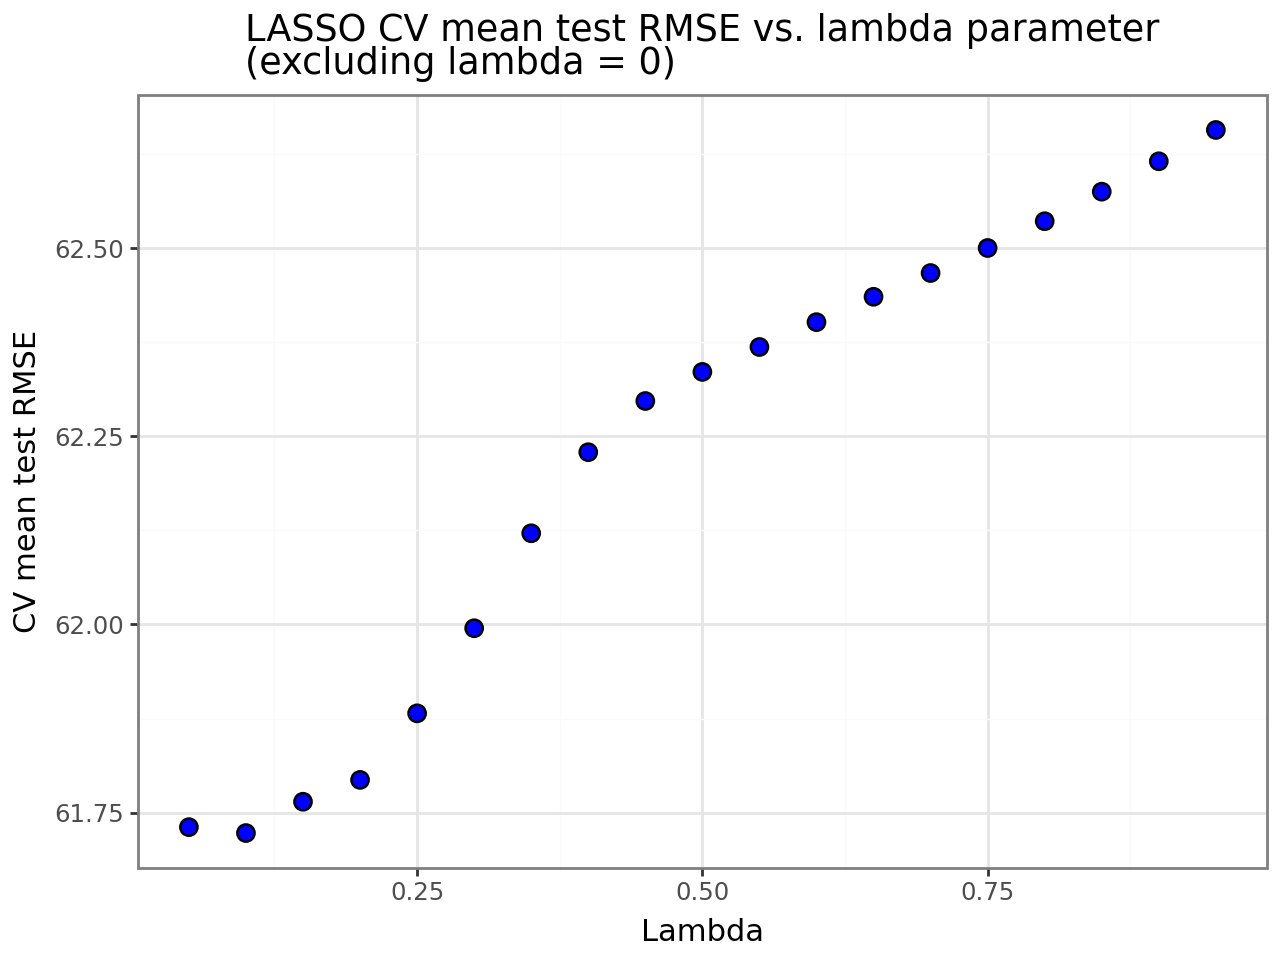

In [74]:
(
    ggplot(pd.DataFrame({'Lambda' : lasso_cv.cv_results_['param_alpha'].data,
                         'Test RMSE' : lasso_cv.cv_results_['mean_test_score']*-1}).iloc[1:,:],
                         aes('Lambda', 'Test RMSE'))
    + geom_point(color = 'black', fill = 'blue', size = 3)
    + theme_bw()
    + labs(title = 'LASSO CV mean test RMSE vs. lambda parameter\n(excluding lambda = 0)',
           y = 'CV mean test RMSE')
)

Now let's take a look at the Random Forest tuning grid! As we have two hyperparameters now, I visualized the cross-validated test RMSE values on a heatmap. It seems from the chart that the grid may have been misspecified, as the minimal RMSE value is at the top right corner, indicating that it may have been beneficial to include smaller minimum samples split and larger maximum number of features values in the tuning grid. However, partly due to computational constraints, and partly because - as we will see - this is already a pretty good model, I will go with the hyperparameters found by this grid search.

Also note, that the Random Forest outperforms both the OLS and the LASSO models (as expected).

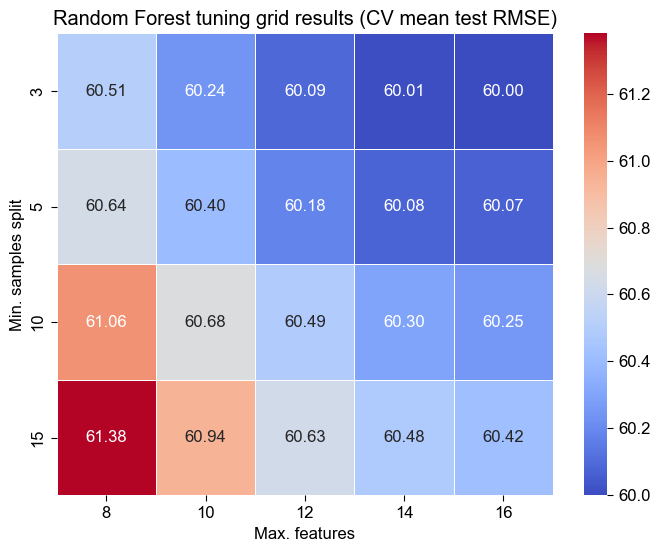

In [76]:
heatmap_data = pd.DataFrame(rf_cv.cv_results_)[
    ["param_max_features", "param_min_samples_split", "mean_test_score"]
].assign(
    mean_test_score=lambda x: x["mean_test_score"] * -1,
    Variables=lambda x: x["param_max_features"],
    Min_nodes=lambda x: x["param_min_samples_split"],
).pivot(
    index="Min_nodes", columns="Variables", values="mean_test_score"
).round(2)

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

plt.xlabel("Max. features")
plt.ylabel("Min. samples split")
plt.title("Random Forest tuning grid results (CV mean test RMSE)")

plt.show()

For the GBM model, the tuning grid indicates that the optimal hyperparameter set-up is indeed a local minimum for the maximum depth, but it may have been beneficial to add lower number of estimators to the gridsearch. However, we might have been able to achieve even better results using a more granular grid. Again, for computational reasons, I will go with this lightly tuned model, as it already outperforms the previous three models.

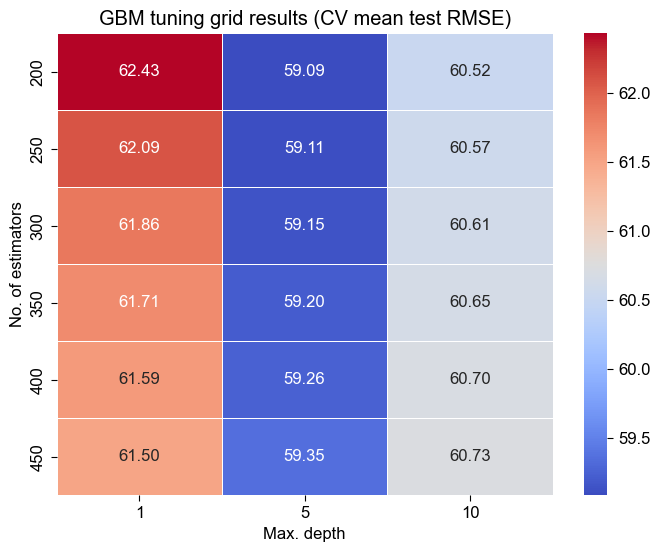

In [77]:
df = pd.DataFrame(gbm_cv.cv_results_)[
    ["param_max_depth", "param_n_estimators", "mean_test_score"]
].assign(
    mean_test_score=lambda x: x["mean_test_score"] * -1
).pivot(
    index="param_n_estimators", columns="param_max_depth", values="mean_test_score"
)

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.xlabel("Max. depth")
plt.ylabel("No. of estimators")
plt.title("GBM tuning grid results (CV mean test RMSE)")
plt.show()


For the XGBoost model, the tuning grid consisted of 6 hyperparameters, so I could not visualize these on a simple heatmap. What I did instead is that I simply listed out the best and worst performing 10 models according to the cross-validated test RMSE. What we can see is that for most of the tuning parameters, the optimal value was found at one endpoint of the provided range, so again, a more extended tuning may have been beneficial. Note however, that even with this tuning, the XGBoost already outperforms the GBM model.

In [78]:
df = pd.DataFrame(xgb_cv.cv_results_)[[
    "mean_test_score",
    "param_colsample_bytree",
    "param_learning_rate",
    "param_max_depth",
    "param_min_child_weight",
    "param_n_estimators"
]].astype(float).round(2)

df.mean_test_score = df.mean_test_score * -1

df.sort_values(by = 'mean_test_score', ascending = True, inplace = True)

df.columns = ['Test RMSE', 'Col. subsample ratio', 'Learning rate', 'Max. depth', 'Min. child weight', 'No. of estimators']

df.reset_index(drop = True, inplace = True)

In [79]:
df.head(10)

Test RMSE  Col. subsample ratio  Learning rate  Max. depth  \
0      58.57                   0.6           0.05         6.0   
1      58.58                   0.6           0.05         6.0   
2      58.63                   0.6           0.05         9.0   
3      58.64                   0.6           0.05         9.0   
4      58.65                   0.6           0.05         6.0   
5      58.66                   0.6           0.05         6.0   
6      58.67                   0.6           0.05         9.0   
7      58.71                   0.6           0.05         9.0   
8      58.71                   0.6           0.05         9.0   
9      58.73                   0.8           0.05         9.0   

   Min. child weight  No. of estimators  
0               10.0              450.0  
1               20.0              450.0  
2               20.0              350.0  
3               20.0              250.0  
4               10.0              350.0  
5               20.0              350.0  
6               20.0              450.0  
7               10.0              350.0  
8               10.0              250.0  
9               20.0              350.0

In [80]:
df.tail(10)

Test RMSE  Col. subsample ratio  Learning rate  Max. depth  \
98       59.95                   1.0           0.10         9.0   
99       59.98                   1.0           0.05         3.0   
100      60.08                   1.0           0.10         9.0   
101      60.12                   1.0           0.10         9.0   
102      60.13                   0.6           0.05         3.0   
103      60.19                   0.6           0.05         3.0   
104      60.24                   0.8           0.05         3.0   
105      60.25                   0.8           0.05         3.0   
106      60.29                   1.0           0.05         3.0   
107      60.30                   1.0           0.05         3.0   

     Min. child weight  No. of estimators  
98                10.0              350.0  
99                20.0              350.0  
100               10.0              450.0  
101               20.0              450.0  
102               20.0              250.0  
103               10.0              250.0  
104               10.0              250.0  
105               20.0              250.0  
106               10.0              250.0  
107               20.0              250.0

To evaluate the model's performance on unseen data, we should re-estimate all of them (with the cross-validated tuning parameters) on the whole train sample (to utilize all available information). Note that we have already done this for the OLS model, so we should only deal with the other four. For easier use later, I incorporate the models into some pipelines.

In [81]:
categorical_columns = [col for col in predictors_ml if col.startswith("f_")]
numerical_columns = [col for col in predictors_ml if col not in categorical_columns]
categorical_encoder = OneHotEncoder(handle_unknown="ignore")
preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", "passthrough", numerical_columns),
    ]
)

In [82]:
y, X = dmatrices("eur_price" + ols_equations[5], data_train)
scaler = StandardScaler()
scaler.fit(X)
lasso_best_pipeline = Pipeline(
    [
        ("scale", scaler),
        ("regressor", lasso),
    ]
)
y, X = dmatrices("eur_price" + ols_equations[5], data_train) # dmatrices does the categorical encoding, so no need for the onehotencoder
lasso_best_pipeline.fit(X, y.ravel())

Pipeline(steps=[('scale', StandardScaler()),
                ('regressor',
                 ElasticNet(alpha=0.1, l1_ratio=1, random_state=9876))])

In [83]:
rf_best_pipeline = Pipeline(
    [
        ("preprocess", preprocessing),
        ("regressor", rf),
    ]
)
rf_best_pipeline.fit(data_train[list(predictors_ml)], data_train.eur_price)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['f_property_type',
                                                   'f_room_type', 'f_bathrooms',
                                                   'f_host_location',
                                                   'f_host_response_time',
                                                   'f_host_listings_count',
                                                   'f_number_of_reviews']),
                                                 ('num', 'passthrough',
                                                  ['n_accomodates',
                                                   'n_bedrooms', 'n_beds',
                                                   'n_distance_to_center',
                                                   'd_instant_bookable',
                                                   'n...
                                                   'd_amenities_heating',
                                                   'd_amenities_tv',
                                                   'd_amenities_hangers',
                                                   'd_amenities_wifi',
                                                   'd_amenities_kitchen',
                                                   'd_amenities_air_conditioning',
                                                   'd_amenities_elevator',
                                                   'd_amenities_essentials',
                                                   'd_amenities_first_aid_kit', ...])])),
                ('regressor',
                 RandomForestRegressor(max_features=16, min_samples_split=3,
                                       n_estimators=250, n_jobs=7,
                                       oob_score=True, random_state=485))])

In [84]:
gbm_best_pipeline = Pipeline(
    [
        ("preprocess", preprocessing),
        ("regressor", gbm),
    ]
)
gbm_best_pipeline.fit(data_train[list(predictors_ml)], data_train.eur_price)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['f_property_type',
                                                   'f_room_type', 'f_bathrooms',
                                                   'f_host_location',
                                                   'f_host_response_time',
                                                   'f_host_listings_count',
                                                   'f_number_of_reviews']),
                                                 ('num', 'passthrough',
                                                  ['n_accomodates',
                                                   'n_bedrooms', 'n_beds',
                                                   'n_distance_to_center',
                                                   'd_instant_bookable',
                                                   'n...
                                                   'flag_n_reviews_per_month',
                                                   'd_amenities_washer',
                                                   'd_amenities_heating',
                                                   'd_amenities_tv',
                                                   'd_amenities_hangers',
                                                   'd_amenities_wifi',
                                                   'd_amenities_kitchen',
                                                   'd_amenities_air_conditioning',
                                                   'd_amenities_elevator',
                                                   'd_amenities_essentials',
                                                   'd_amenities_first_aid_kit', ...])])),
                ('regressor',
                 GradientBoostingRegressor(max_depth=5, min_samples_split=20,
                                           n_estimators=200,
                                           random_state=31))])

In [85]:
xgb_best_pipeline = Pipeline(
    [
        ("preprocess", preprocessing),
        ("regressor", xgb),
    ]
)
xgb_best_pipeline.fit(data_train[list(predictors_ml)], data_train.eur_price)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['f_property_type',
                                                   'f_room_type', 'f_bathrooms',
                                                   'f_host_location',
                                                   'f_host_response_time',
                                                   'f_host_listings_count',
                                                   'f_number_of_reviews']),
                                                 ('num', 'passthrough',
                                                  ['n_accomodates',
                                                   'n_bedrooms', 'n_beds',
                                                   'n_distance_to_center',
                                                   'd_instant_bookable',
                                                   'n...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=6, max_leaves=None, min_child_weight=10,
                              missing=nan, monotone_constraints=None,
                              multi_strategy=None, n_estimators=450,
                              n_jobs=None, num_parallel_tree=None,
                              random_state=56, ...))])

Having refitted the models on the whole training set, we can now evaluate their performance on unseen data. For this, I make a prediction on the hold-out set with all of the models, than calculate the RMSE values of these predictions.

In [86]:
hold_out_rmse = {}

In [87]:
y, X = dmatrices("eur_price" + ols_equations[3], data_holdout)
hold_out_rmse['ols'] = mean_squared_error(y, ols.predict(X), squared = False)

In [88]:
y, X = dmatrices("eur_price" + ols_equations[5], data_holdout)
hold_out_rmse['lasso'] = mean_squared_error(y, lasso_best_pipeline.predict(X), squared = False)

In [89]:
hold_out_rmse['rf'] = mean_squared_error(data_holdout['eur_price'], rf_best_pipeline.predict(data_holdout[list(predictors_ml)]), squared = False)

In [90]:
hold_out_rmse['gbm'] = mean_squared_error(data_holdout['eur_price'], gbm_best_pipeline.predict(data_holdout[list(predictors_ml)]), squared = False)

In [91]:
hold_out_rmse['xgb'] = mean_squared_error(data_holdout['eur_price'], xgb_best_pipeline.predict(data_holdout[list(predictors_ml)]), squared = False)

Now that we have both training time and RMSE data (both for the hold-out sample and the cross-validated test RMSE), let's create a horserace chart! Note that I included an adjusted time column as well, as the OLS and LASSO models have not been estimated on multiple cores. Thus I included an adjustment for them, assuming 80% parallelization efficiency, so that the timing values become comparable.

*Technical note: taking the max of the test scores, as these are negative values.*

In [92]:
cv_test_rmse = {
    'ols' : pd.DataFrame(ols_cv)['Test RMSE'].iloc[3],
    'lasso' : lasso_cv.cv_results_['mean_test_score'].max()*-1,
    'rf' : rf_cv.cv_results_['mean_test_score'].max()*-1,
    'gbm' : gbm_cv.cv_results_['mean_test_score'].max()*-1,
    'xgb' : xgb_cv.cv_results_['mean_test_score'].max()*-1,
}

In [93]:
horserace = pd.DataFrame({
    'CV test RMSE' : cv_test_rmse,
    'Hold-out set RMSE': hold_out_rmse,
    'Training time (m)': model_times
})

def adjust_for_parallelization(time, num_cores=8, efficiency=0.8):
    return time / (num_cores * efficiency + (1 - efficiency))

horserace['Adj. training time (assuming all cores used, m)'] = horserace['Training time (m)']
horserace.loc[['ols', 'lasso'], 'Adj. training time (assuming all cores used, m)'] = horserace.loc[['ols', 'lasso'], 'Training time (m)'].apply(adjust_for_parallelization)
horserace.index = ['OLS', 'LASSO', 'Random Forest', 'GBM', 'XGBoost']

horserace['CV test RMSE'] = round(horserace['CV test RMSE'], 2)
horserace['Hold-out set RMSE'] = round(horserace['Hold-out set RMSE'], 2)
horserace['Training time (m)'] = round(horserace['Training time (m)'] / 60, 2)
horserace['Adj. training time (assuming all cores used, m)'] = round(horserace['Adj. training time (assuming all cores used, m)'] / 60, 2)


What we can deduce from the below horserace table is the following:

- Hold-out set RMSE values are very close to CV test RMSE values for all models. For OLS and LASSO, the hold-out RMSE is slightly higher, while for the tree-based models, it is marginally lower. This suggests that none of the models suffer from major overfitting, and their cross-validation performance generalizes well to the hold-out set.
- As expected, the hold-out RMSE decreases as model complexity increases, with XGBoost achieving the best predictive performance. This confirms that more sophisticated models with tree-based architectures tend to extract additional predictive power from the data.
- There is a clear trade-off between model complexity and training time. While more complex models tend to perform better, they also require significantly longer to train. The most extreme case is GBM, which takes over 18 minutes to train—far more than any other model. Given that XGBoost achieves a very similar RMSE but trains nearly four times faster, using GBM may not be justifiable in practical applications.
- While the Random Forest model also performs well, its training time is notably higher than LASSO while offering only a modest improvement in RMSE. However, unlike GBM, its training time remains within a reasonable range, making it a strong candidate for further consideration.
- OLS and LASSO remain viable options for those prioritizing speed and interpretability. Both models train extremely fast (especially when considering parallel processing for LASSO) and still achieve competitive RMSEs. However, they lag behind in predictive accuracy compared to tree-based models.

Thus, if we are willing to sacrifice interpretability for predictive power, the best trade-offs appear to be Random Forest and XGBoost. Since XGBoost achieves the lowest RMSE while maintaining a relatively low training time, it seems to be the strongest candidate overall. In the next section, I will further analyze the Random Forest and XGBoost models.

In [94]:
horserace

CV test RMSE  Hold-out set RMSE  Training time (m)  \
OLS                   61.77              62.67               0.24   
LASSO                 61.72              62.22               3.66   
Random Forest         60.00              59.70               5.43   
GBM                   59.09              58.98              18.61   
XGBoost               58.57              58.17               4.49   

               Adj. training time (assuming all cores used, m)  
OLS                                                       0.04  
LASSO                                                     0.55  
Random Forest                                             5.43  
GBM                                                      18.61  
XGBoost                                                   4.49

### 1.4. Analysis of Random Forest and XGBoost models

To analyze and somewhat understand the Random Forest and XGBoost models, I first draw up some variable importance plots. Importantly, I calculate grouped importance values for factor variables. **Note that running the `permutation_importance` function calls takes a few minutes.**

I present plots showing all variables above a 1% importance cutoff, and also separately only the top 10 most important variables.

In [95]:
result = permutation_importance(
    rf_best_pipeline,
    data_train[list(predictors_ml)],
    data_train.eur_price,
    n_repeats=10,
    random_state=45,
    n_jobs=-1,
)

In [96]:
grouped_imp = (
    pd.DataFrame(result.importances_mean, data_train[list(predictors_ml)].columns)
    .reset_index()
    .rename({"index": "varname", 0: "imp"}, axis=1)
    .assign(imp_percentage=lambda x: x["imp"] / x["imp"].sum())
    .sort_values(by=["imp"], ascending=False)
)

In [99]:
rf_varimp_plot_all = (
    ggplot(
        grouped_imp.loc[lambda x: x.imp_percentage > 0.01],
        aes(x="reorder(varname, imp)", y="imp_percentage"),
    )
    + geom_point(color='blue', size=2.5)
    + geom_segment(
        aes(x="varname", xend="varname", y=0, yend="imp_percentage"),
        color='blue',
        size=2,
    )
    + ylab("Importance (Percent)")
    + xlab("Variable Name")
    + coord_flip()
    + ggtitle("Random Forest - Variable importance (above 1% cutoff)")
    + scale_y_continuous(labels=percent_format())
    + theme_bw()
)

rf_varimp_plot_top = (
    ggplot(
        grouped_imp.head(10),
        aes(x="reorder(varname, imp)", y="imp_percentage"),
    )
    + geom_point(color='blue', size=2.5)
    + geom_segment(
        aes(x="varname", xend="varname", y=0, yend="imp_percentage"),
        color='blue',
        size=2,
    )
    + ylab("Importance (Percent)")
    + xlab("Variable Name")
    + coord_flip()
    + ggtitle("Random Forest - Top 10 most important variables")
    + scale_y_continuous(labels=percent_format())
    + theme_bw()
)

In [100]:
xgb_result = permutation_importance(
    xgb_best_pipeline,
    data_train[list(predictors_ml)],
    data_train.eur_price,
    n_repeats=10,
    random_state=45,
    n_jobs=-1,
)

In [101]:
xgb_grouped_imp = (
    pd.DataFrame(xgb_result.importances_mean, data_train[list(predictors_ml)].columns)
    .reset_index()
    .rename({"index": "varname", 0: "imp"}, axis=1)
    .assign(imp_percentage=lambda x: x["imp"] / x["imp"].sum())
    .sort_values(by=["imp"], ascending=False)
)

In [102]:
xgb_varimp_plot_all = (
    ggplot(
        xgb_grouped_imp.loc[lambda x: x.imp_percentage > 0.01],
        aes(x="reorder(varname, imp)", y="imp_percentage"),
    )
    + geom_point(color='blue', size=2.5)
    + geom_segment(
        aes(x="varname", xend="varname", y=0, yend="imp_percentage"),
        color='blue',
        size=2,
    )
    + ylab("Importance (Percent)")
    + xlab("Variable Name")
    + coord_flip()
    + ggtitle("XGBoost - Variable importance (above 1% cutoff)")
    + scale_y_continuous(labels=percent_format())
    + theme_bw()
)

xgb_varimp_plot_top = (
    ggplot(
        xgb_grouped_imp.head(10),
        aes(x="reorder(varname, imp)", y="imp_percentage"),
    )
    + geom_point(color='blue', size=2.5)
    + geom_segment(
        aes(x="varname", xend="varname", y=0, yend="imp_percentage"),
        color='blue',
        size=2,
    )
    + ylab("Importance (Percent)")
    + xlab("Variable Name")
    + coord_flip()
    + ggtitle("XGBoost - Top 10 most important variables")
    + scale_y_continuous(labels=percent_format())
    + theme_bw()
)

Looking at the variable importance plots, we can see that both models have identified more or less the same variables as the most important. This is best illustrated by the fact that 8 out of the top 10 most important variables are common between the two models. This consistency suggests that these features hold genuine predictive power across different modeling approaches.

An important difference between the two models is that the Random Forest's variable importance is more balanced compared to XGBoost's. The XGBoost model places a disproportionately high weight on the `n_distance_to_center` variable, assigning it nearly 25% importance, whereas the remaining features contribute significantly less. This suggests that XGBoost heavily relies on this single variable to make predictions. In contrast, the Random Forest model distributes importance more evenly across multiple variables, with a much less steep decline in importance scores. This means that while XGBoost focuses more on a few key predictors, the Random Forest model considers a broader set of variables when making decisions.

This difference has implications for interpretation and robustness. While XGBoost’s reliance on a dominant variable might lead to a more efficient and possibly stronger predictive model, it also raises the risk of the model being overly sensitive to that specific feature. If `n_distance_to_center` were measured with noise or had missing values, the model’s performance could degrade more substantially than Random Forest, which spreads importance across a wider range of predictors.

Additionally, the presence of time-related host characteristics (`n_days_since_first_rev`, `n_host_since`, `f_host_response_time`, etc.) in both models’ top importance rankings suggests that historical hosting activity plays a notable role in determining the target variable. The emphasis on review-related features (`n_reviews_per_month`, `p_host_acceptance_rate`, `n_review_scores_rating`) further reinforces the idea that guest feedback and host behavior significantly impact the outcome.

Overall, these differences suggest that while XGBoost may provide the best predictive accuracy, Random Forest could be a more robust choice if we prioritize stability across different data distributions. Depending on the use case, the trade-off between peak performance and interpretability should be carefully considered.

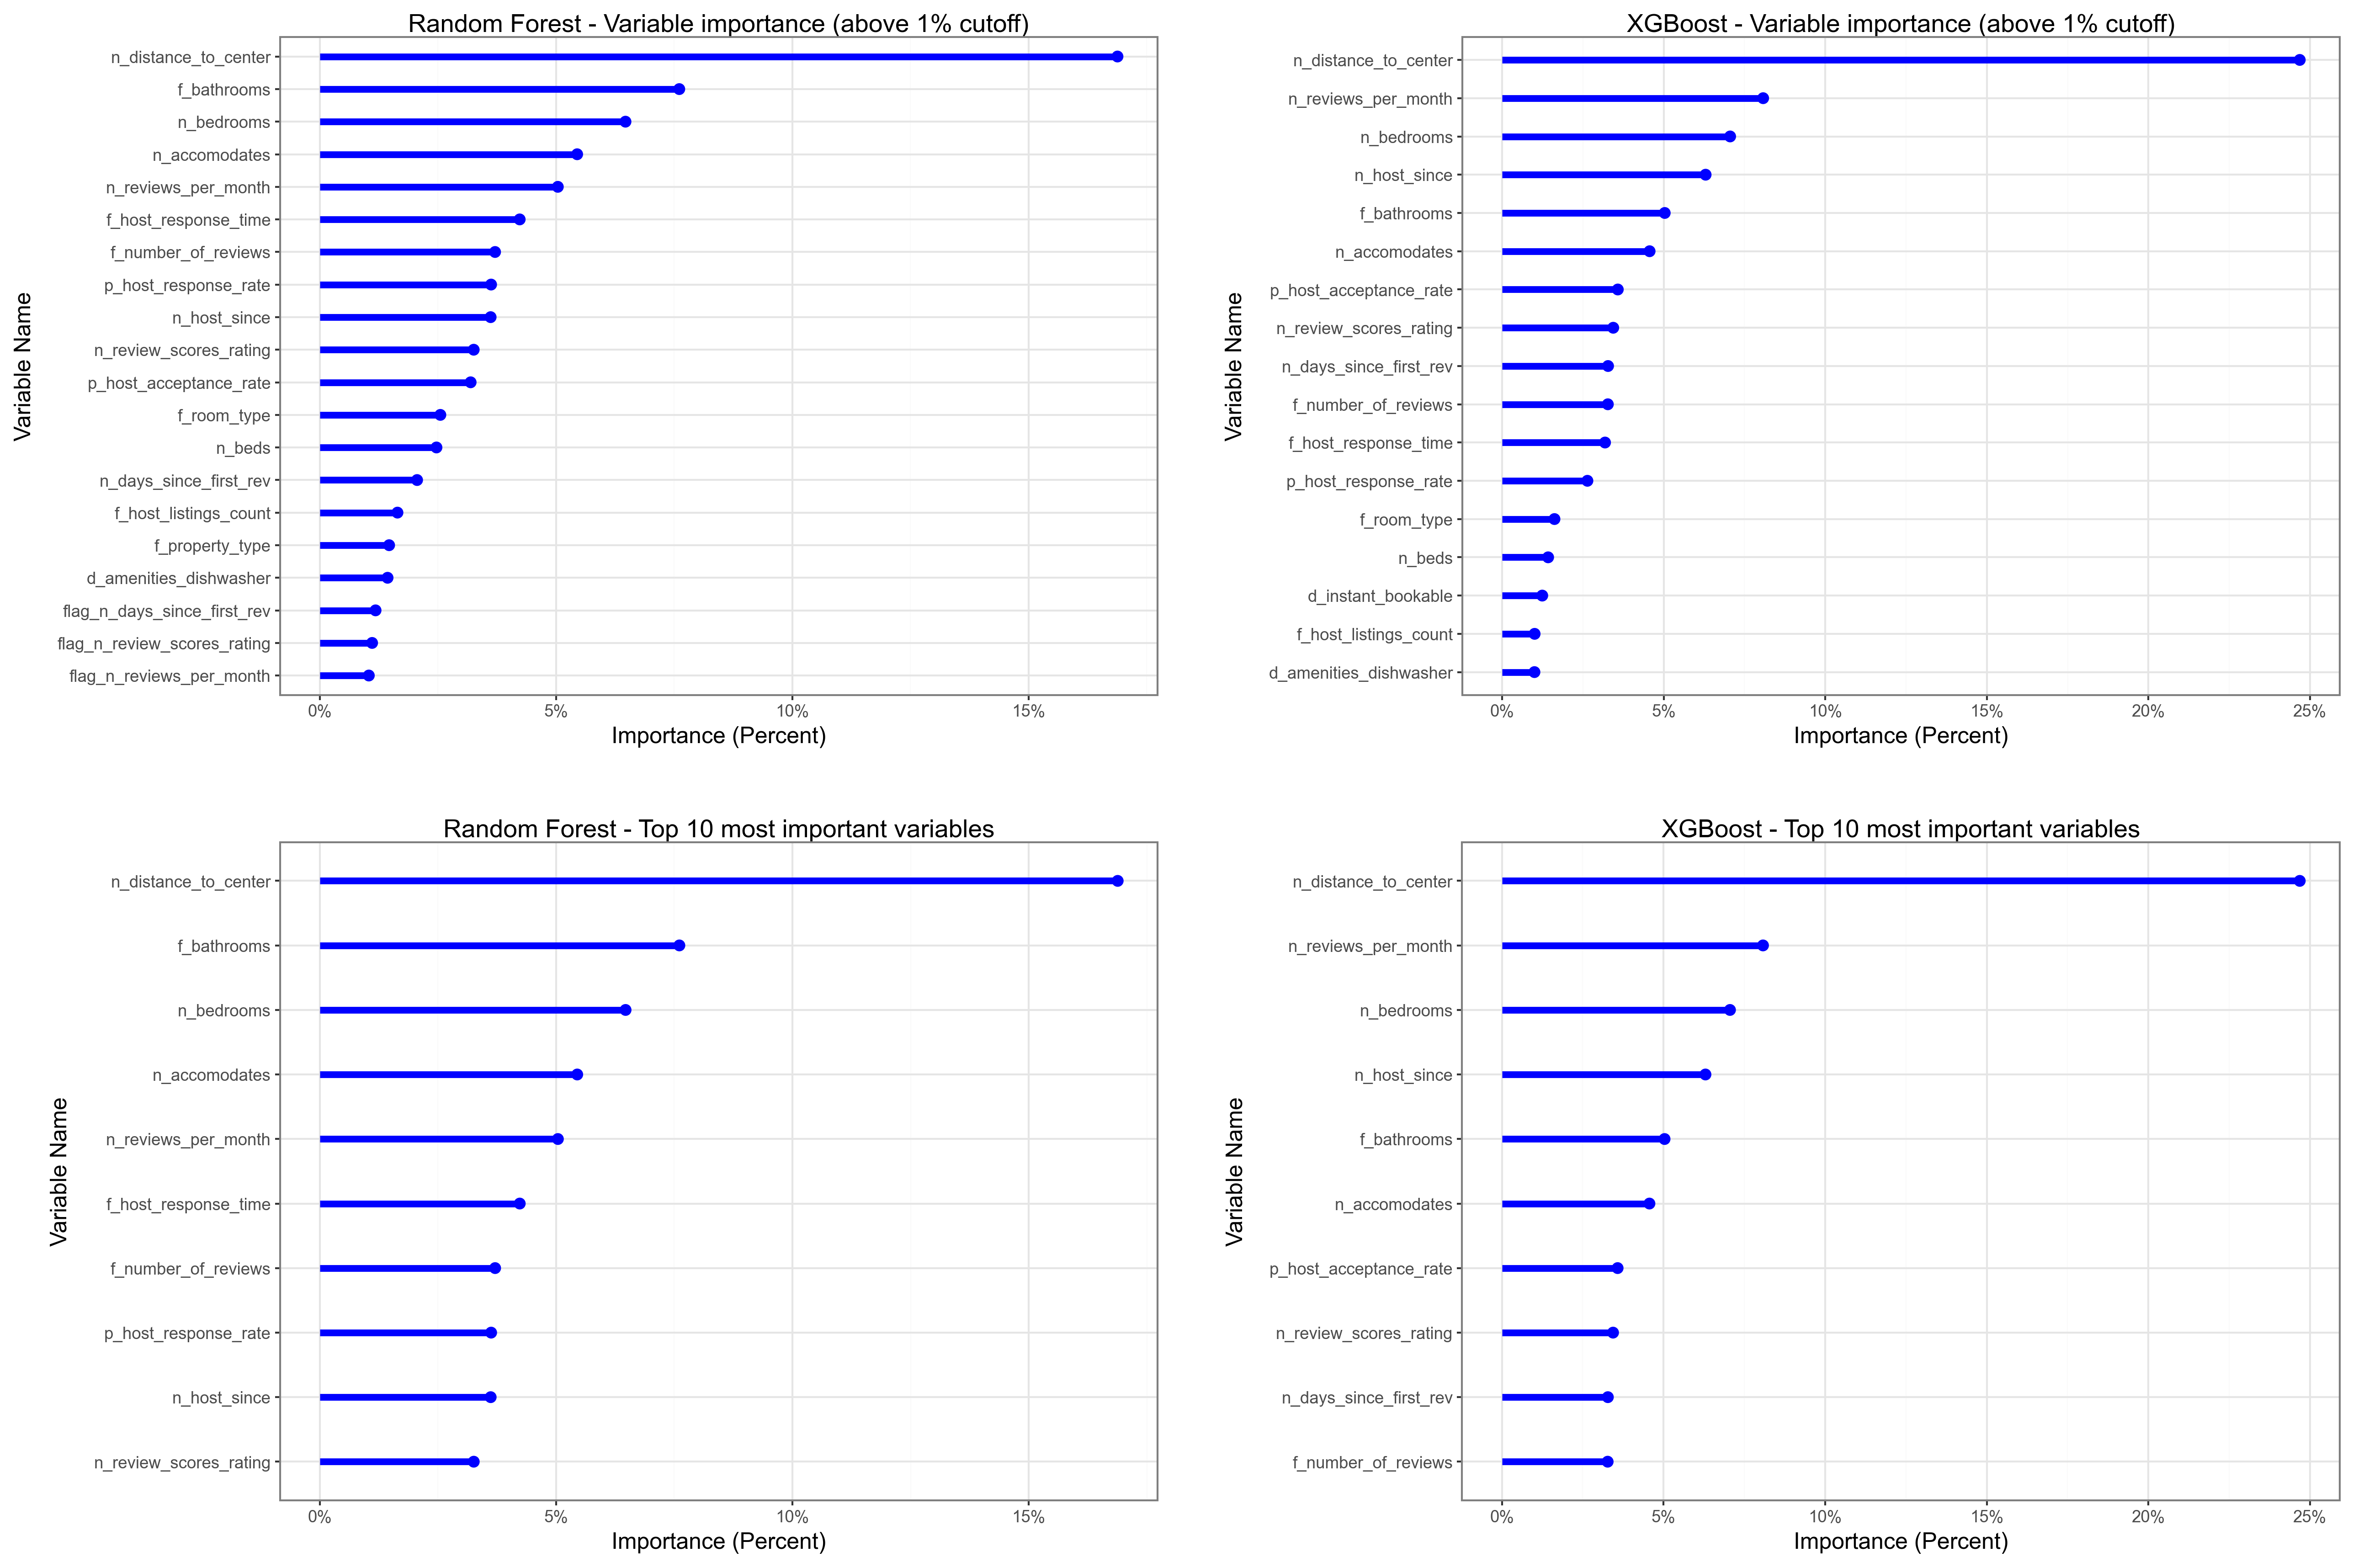

In [103]:
pw.basefigure.clear()
display((pw.load_ggplot(rf_varimp_plot_all) | pw.load_ggplot(xgb_varimp_plot_all)) / ((pw.load_ggplot(rf_varimp_plot_top) | pw.load_ggplot(xgb_varimp_plot_top))))

To go deeper into the most important variables, I show a partial dependence plot for each model's top 5 variables (on the hold-out set). For this, I mainly use the SHAP package (except for categorical variables, for which I use `sklearn`'s `partial_dependence`). As the codes generating the plots are rather long, I wrapped it inside a function.

In [104]:
def plot_partial_dependence_comparison(feature, data_holdout, pipeline1, pipeline2, fig1_title, fig2_title):
    fig1, ax1 = shap.partial_dependence_plot(
        feature,
        pipeline1.predict,
        data_holdout,
        model_expected_value=False,
        feature_expected_value=False,
        ice=False,
        show=False
    )
    plt.close()

    fig2, ax2 = shap.partial_dependence_plot(
        feature,
        pipeline2.predict,
        data_holdout,
        model_expected_value=False,
        feature_expected_value=False,
        ice=False,
        show=False
    )
    plt.close()

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    fig1.canvas.draw()
    fig2.canvas.draw()

    axes[0].imshow(fig1.canvas.buffer_rgba())
    axes[1].imshow(fig2.canvas.buffer_rgba())

    for ax in axes:
        ax.axis("off")

    axes[0].set_title(fig1_title)
    axes[1].set_title(fig2_title)
    
    plt.tight_layout()
    plt.show()


**`n_distance_to_center` - #1 for both models**

For the distance to the center, both models suggest a non-linear, negative pattern. An interesting difference is that the Random Forest seems smoother, whereas the XGBoost is quite spiky. This may indicate that the latter model is somewhat overfitted, as it may have learned some patterns that were actually just noise in the data. Nonetheless, both plots suggest that listings further away from the center are less and less expensive. Importantly, both models have a slight upturn around 8 kilometers—this may be due to the low number of observations at that range. This pattern suggests that location is a dominant factor in determining Airbnb prices, with proximity to the city center being a major driver of higher prices. The upturn at larger distances might also indicate the presence of highly-priced accommodations in suburban or scenic areas, which could skew the trend slightly.

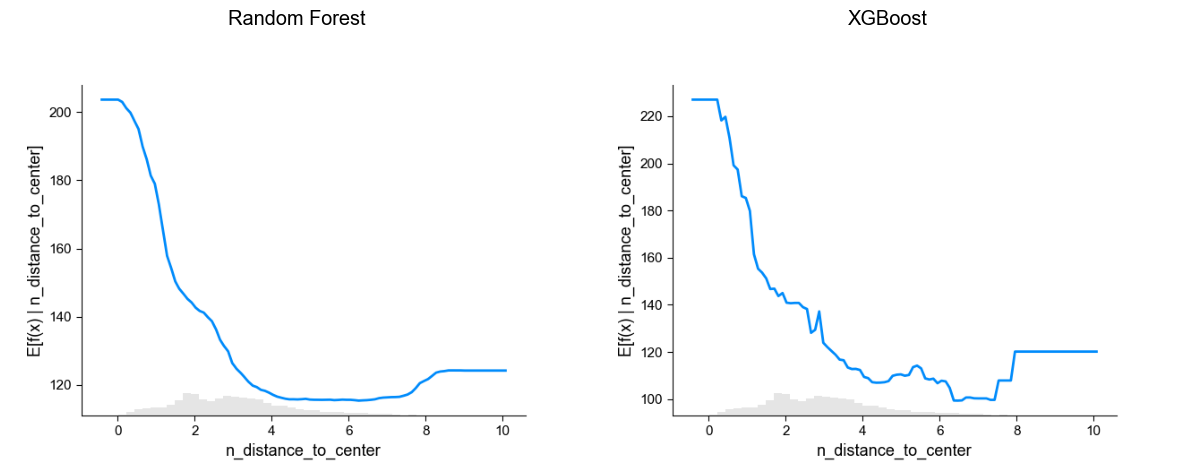

In [107]:
plot_partial_dependence_comparison('n_distance_to_center', data_holdout, rf_best_pipeline, xgb_best_pipeline, 'Random Forest', 'XGBoost')

**`n_reviews_per_month` - #5 for RF, #2 for XGBoost** 

As for the number of reviews per month, both models suggest a steeply declining relationship, which turns into practically zero after around 10 reviews per month. Once again, the XGBoost chart is more jagged than the Random Forest, likely due to its more complex functional form. The decline is sharp, reinforcing the idea that a higher number of reviews per month does not necessarily correlate with a higher price. This may suggest that properties with frequent bookings (hence, more reviews) might be priced more competitively to attract a steady stream of guests. On the other hand, premium listings with fewer guests per month could maintain higher price points despite receiving fewer reviews, explaining the declining pattern observed.

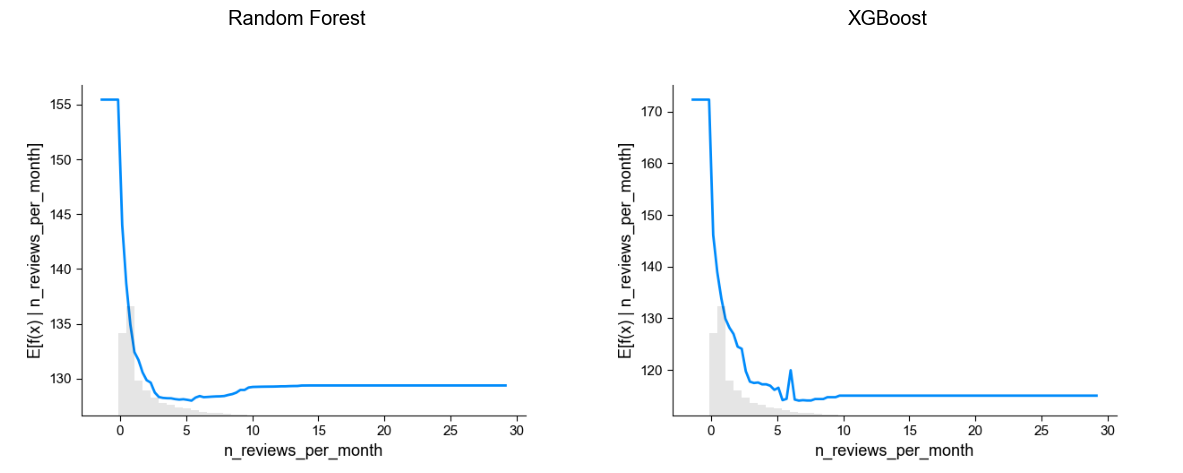

In [108]:
plot_partial_dependence_comparison('n_reviews_per_month', data_holdout, rf_best_pipeline, xgb_best_pipeline, 'Random Forest', 'XGBoost')

**`f_bathrooms` - #2 for RF, #5 for XGBoost**

Concerning the number of bathrooms, both models suggest that listings with more bathrooms are generally more expensive, though the exact price difference between bathroom count categories differs. Interestingly, listings with no bathrooms are priced higher by both models than those with at least one bathroom. This could indicate that observations with zero bathrooms might represent missing or erroneous data rather than actual listings without bathrooms. Furthermore, the price increase associated with additional bathrooms is not uniform, implying that after a certain point, extra bathrooms contribute less to price appreciation. This could be due to diminishing marginal returns, where adding a second or third bathroom has a much smaller impact than the first.

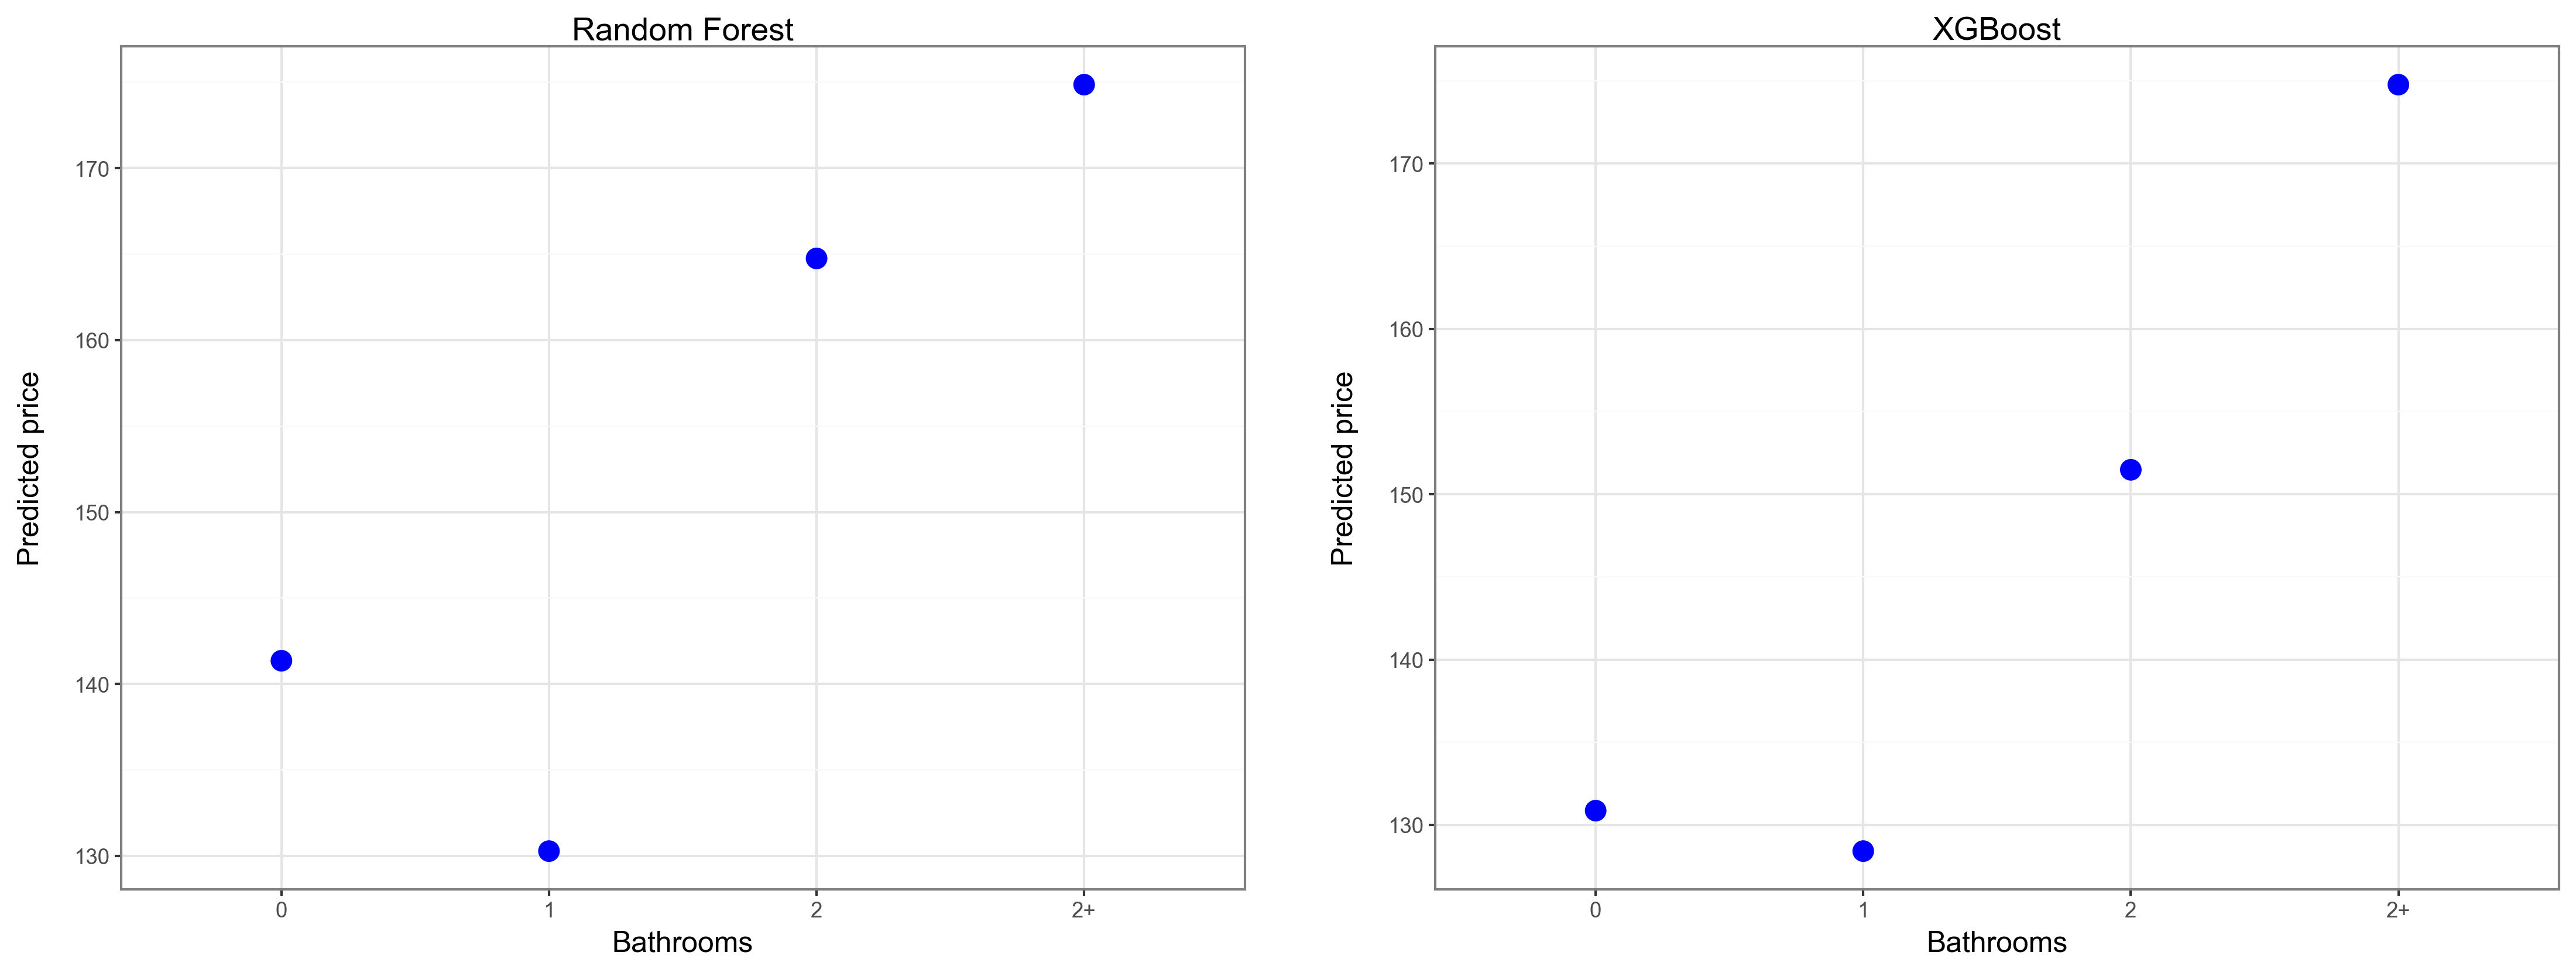

In [114]:
pw.basefigure.clear()
rf_bathroom_pdp = partial_dependence(
    rf_best_pipeline, data_holdout[list(predictors_ml)], ["f_bathrooms"], kind="average"
)

rf_bathroom_pdp = (
    pd.DataFrame(rf_bathroom_pdp["average"], columns=rf_bathroom_pdp["grid_values"][0].tolist())
    .T.reset_index()
    .rename({0: "Predicted price", "index": "Bathrooms"}, axis=1)
)

p1 = (
    ggplot(rf_bathroom_pdp, aes(x="Bathrooms", y="Predicted price"))
    + geom_point(color='blue', size=4)
    + theme_bw()
    + labs(title = 'Random Forest')
)

xgb_bathroom_pdp = partial_dependence(
    xgb_best_pipeline, data_holdout[list(predictors_ml)], ["f_bathrooms"], kind="average"
)

xgb_bathroom_pdp = (
    pd.DataFrame(xgb_bathroom_pdp["average"], columns=xgb_bathroom_pdp["grid_values"][0].tolist())
    .T.reset_index()
    .rename({0: "Predicted price", "index": "Bathrooms"}, axis=1)
)

p2 = (
    ggplot(xgb_bathroom_pdp, aes(x="Bathrooms", y="Predicted price"))
    + geom_point(color='blue', size=4)
    + theme_bw()
    + labs(title = 'XGBoost')
)

display(pw.load_ggplot(p1) | pw.load_ggplot(p2))

**`n_bedrooms` - #3 for both models** 

The relationship between price and the number of bedrooms is very similar for both models, suggesting that an increased number of bedrooms is associated with a higher price. The price difference between each step is not equal, indicating that beyond a certain point, additional bedrooms contribute less to the overall price increase. This pattern makes sense, as having more bedrooms typically allows for more guests, increasing the potential value of the listing. However, price appreciation slows down at higher bedroom counts, possibly because luxury listings are already priced at a premium, or because demand for very large Airbnb units is limited compared to smaller, more affordable options.

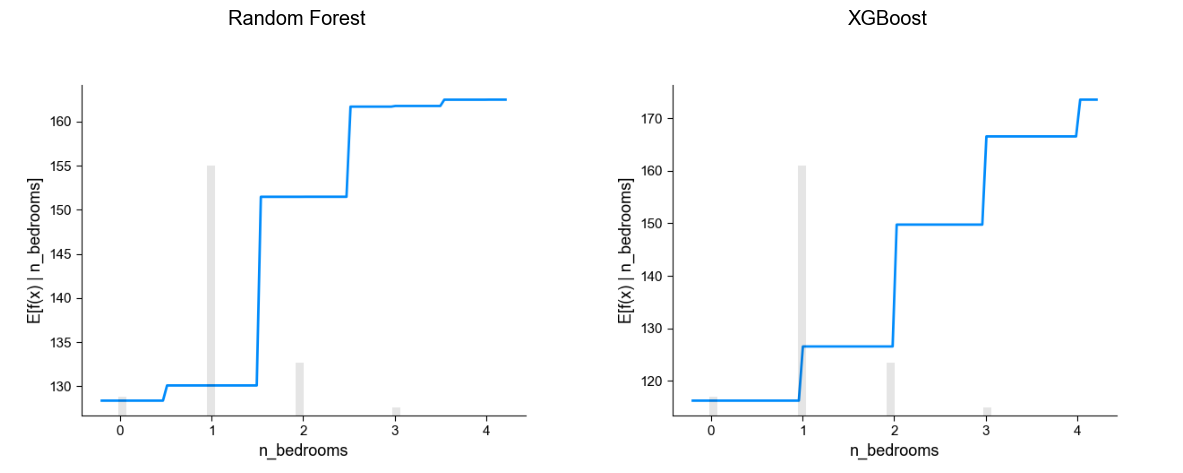

In [111]:
plot_partial_dependence_comparison('n_bedrooms', data_holdout, rf_best_pipeline, xgb_best_pipeline, 'Random Forest', 'XGBoost')

**`n_host_since` - #9 for RF, #4 for XGBoost**

The more jagged prediction for XGBoost is even more apparent in the case of the `n_host_since` variable. Here, the Random Forest shows a rather simple U-shaped relationship. In contrast, XGBoost produces a highly fluctuating pattern, making the U-shape hardly identifiable. The U-shape observed in the Random Forest suggests that price is expected to be lower for listings with hosts who have been active for a longer time. However, this pattern reverses at around 10 years, after which Airbnb listings with longer-tenured hosts become more expensive. This may indicate that experienced hosts have built a reputation and offer premium services, allowing them to command higher prices. Alternatively, newer hosts might initially price competitively to attract guests, explaining the lower prices in the earlier years.

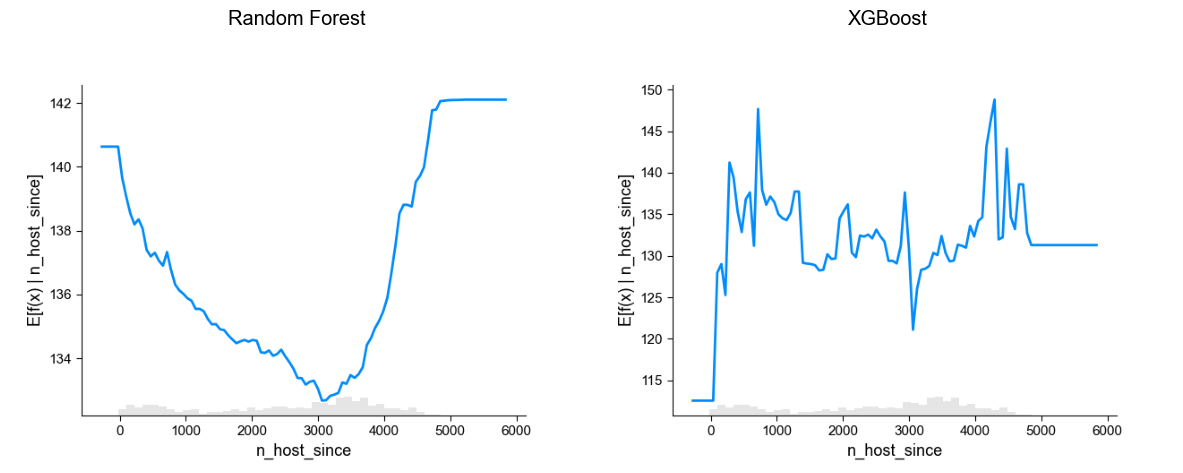

In [112]:
plot_partial_dependence_comparison('n_host_since', data_holdout, rf_best_pipeline, xgb_best_pipeline, 'Random Forest', 'XGBoost')

**`n_accommodates` - #4 for RF, #6 for XGBoost**

Similar to the number of bedrooms, both models suggest that the more people an Airbnb can accommodate, the higher the price. Again, the price difference between each value is not uniform, and the two models suggest different price differences. XGBoost shows a slightly steeper increase than Random Forest, potentially indicating that it captures more interactions between this variable and others. The price increase is most substantial in the first few steps, meaning that moving from a single-occupancy listing to a two- or three-person listing has a larger impact than moving from, say, eight to nine guests. This pattern aligns with market expectations, as smaller accommodations are often highly competitive, while larger properties cater to more niche demand and may not see the same proportional price increase.the number of bedrooms, we can observe that both models suggest that the more people can be accomodated in an AirBnB, the higher the price is. Again, the price difference between each value is not uniform, and the two models suggest different price differences.

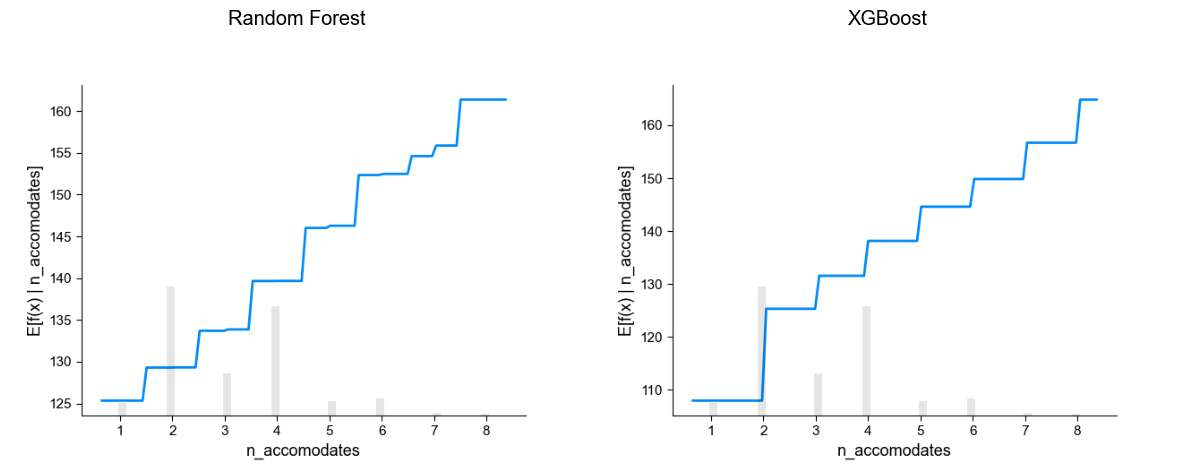

In [113]:
plot_partial_dependence_comparison('n_accomodates', data_holdout, rf_best_pipeline, xgb_best_pipeline, 'Random Forest', 'XGBoost')

Some key takeaways of the above charts:

- XGBoost shows more jagged, high-variance patterns, which might be a sign of overfitting or simply a more complex functional form.
- Random Forest tends to produce smoother relationships, especially for continuous variables, making it potentially more interpretable.
- Both models agree on overall trends but differ in how they capture nuances.
- The most dominant predictor (`n_distance_to_center`) has a strong, non-linear effect in both models, reinforcing its significance in determining Airbnb prices.

Next, let's compare the two models according to SHAP values as well. Note that here, I did not display the plots next to each other as that way they would have been too cramped. Also, I only show the beeswarm plots, as I believe these are the most informative.

# Note: computing SHAP values may take a considerable amount of time, so you can also import the SHAP values from dill files later.

In [115]:
X_encoded = rf_best_pipeline["preprocess"].transform(data_holdout.filter(list(predictors_ml)))
new_feature_names = [
    i.replace("cat__", "").replace("num__", "")
    for i in rf_best_pipeline["preprocess"].get_feature_names_out()
]
X_holdout = pd.DataFrame(X_encoded, columns=new_feature_names)

# without approximation, running this took many hours
rf_explainer = shap.TreeExplainer(rf_best_pipeline["regressor"], approximate = True)
rf_shap_values = rf_explainer(X_holdout)

In [150]:
with open(Path("rf_shap_values.dill"), "wb") as f:
    dill.dump(rf_shap_values, f)

In [116]:
X_encoded = xgb_best_pipeline["preprocess"].transform(data_holdout.filter(list(predictors_ml)))
new_feature_names = [
    i.replace("cat__", "").replace("num__", "")
    for i in xgb_best_pipeline["preprocess"].get_feature_names_out()
]
X_holdout = pd.DataFrame(X_encoded, columns=new_feature_names)

xgb_explainer = shap.TreeExplainer(xgb_best_pipeline["regressor"])
xgb_shap_values = xgb_explainer(X_holdout)

In [153]:
with open(Path("xgb_shap_values.dill"), "wb") as f:
    dill.dump(xgb_shap_values, f)

# NOTE: Run from here again, to import the pre-calculated SHAP-values from dills.

In [154]:
with open(Path("rf_shap_values.dill"), "rb") as f:
    rf_shap_values = dill.load(f)
with open(Path("xgb_shap_values.dill"), "rb") as f:
    xgb_shap_values = dill.load(f)

For both models, the features deemed the most important by the SHAP values align with the variable importance rankings. The most influential predictor is distance to the center, exhibiting a broad range of SHAP values. The color gradient suggests that properties closer to the city center (lower values) tend to have higher predicted prices, while those farther away see a negative impact on price. This aligns with expectations, as central locations are typically more desirable and expensive.

The second most important factor is the number of bedrooms, where a higher count is associated with increased price predictions. This relationship is intuitive, as larger apartments or houses generally command higher prices. Similarly, the number of people accommodated follows a similar trend, with higher values leading to higher predictions, reinforcing the relationship between property size and price. However, the SHAP spread suggests some variation in the relationship, likely influenced by additional factors such as property type and amenities.

The number of reviews per month is another key feature affecting price, with lower review frequencies often associated with higher price predictions. This could be indicative of a trade-off between exclusivity and popularity: high-priced properties may have fewer bookings and, consequently, fewer reviews, while budget-friendly listings tend to have a higher turnover and accumulate more frequent reviews.

The bathroom variable, shown separately for each category, complicates direct interpretation (as opposed to the variable importance and partial dependence plots).

For the XGBoost model, the `n_host_since` variable (how long the host has been active) emerges as a highly relevant predictor. However, its effect on price is ambiguous — higher values contribute both positively and negatively, suggesting an interaction effect with other features. More experienced hosts may price their properties optimally, while newer hosts may set competitive prices to attract initial bookings.

Interestingly, additional variables such as days since first review, host response rate, and presence of specific amenities (e.g., dishwasher) also play a role in shaping price predictions in the XGBoost model.

Overall, both models highlight key structural and location-based features as primary price determinants, while host-related attributes introduce additional nuance. The interaction effects observed in SHAP values suggest that pricing dynamics are influenced by a combination of property characteristics, host behavior, and guest preferences.

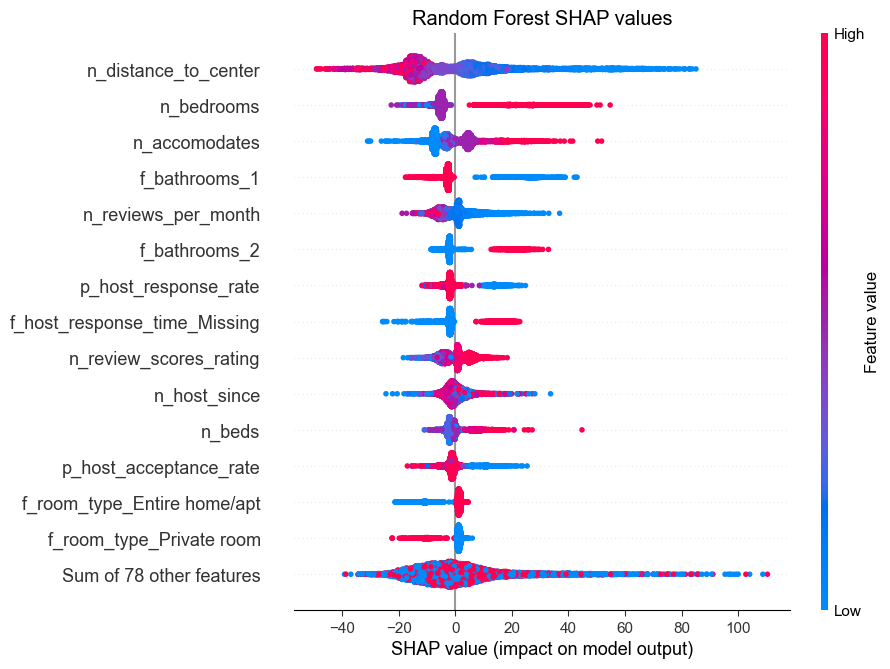

In [118]:
shap.plots.beeswarm(rf_shap_values, max_display = 15, show = False)
plt.title('Random Forest SHAP values')
plt.show()

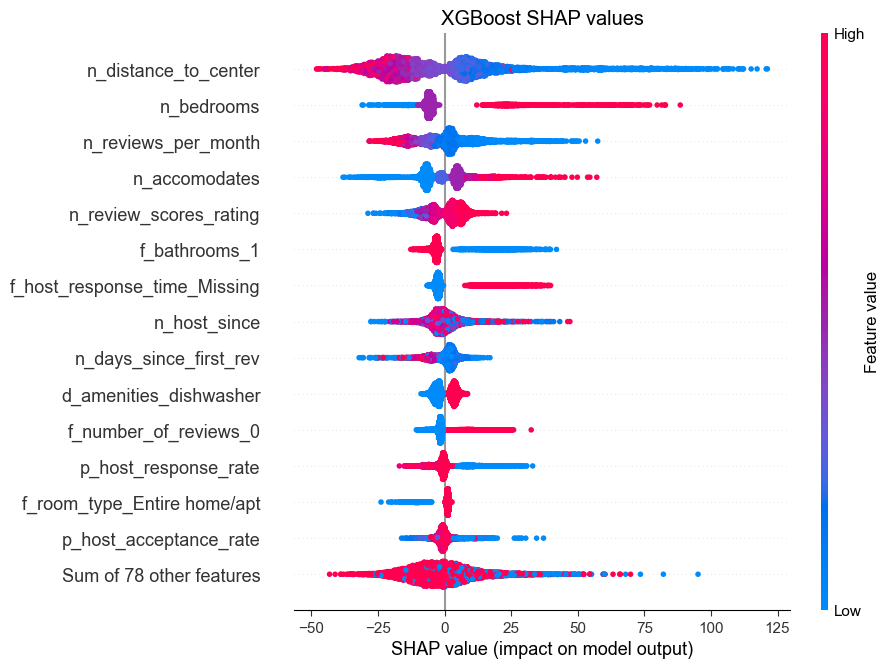

In [119]:
shap.plots.beeswarm(xgb_shap_values, max_display = 15, show = False)
plt.title('XGBoost SHAP values')
plt.show()

Out of pure curiosity, we can check with SHAP what might be the most suitable interaction variable for `n_host_since`. For the Random Forest model, the package suggest the host response rate, while for the XGBoost model, the host acceptance rate. This might explain what we have seen and noted on the beeswarm plots.

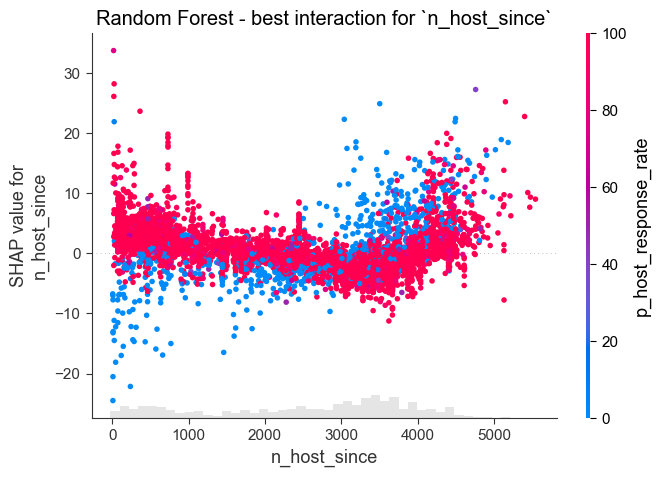

In [121]:
shap.plots.scatter(rf_shap_values[:, "n_host_since"], color=rf_shap_values, show=False)
plt.title('Random Forest - best interaction for n_host_since')
plt.show()

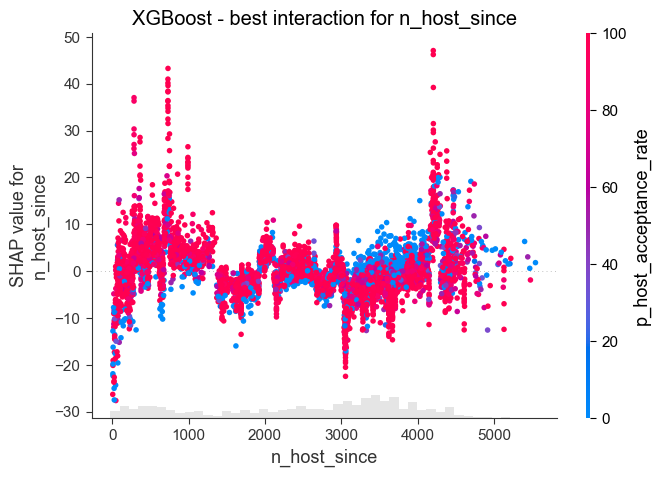

In [122]:
shap.plots.scatter(xgb_shap_values[:, "n_host_since"], color=xgb_shap_values, show=False)
plt.title('XGBoost - best interaction for n_host_since')
plt.show()

The next thing to do is to check the performance of our models on certain subsamples. This might help us understand the constraints of our models and assess under which circumstances we can expect good predictive performance.

In [123]:
data_holdout_pred = data_holdout.assign(
    rf_pred = rf_best_pipeline.predict(data_holdout[list(predictors_ml)]),
    xgb_pred = xgb_best_pipeline.predict(data_holdout[list(predictors_ml)])
)

In [124]:
def calculate_rmse(groupby_obj, model):
    if model == 'rf':
        return (
            groupby_obj.apply(
                lambda x: mean_squared_error(x.rf_pred, x.eur_price, squared=False),
            )
            .to_frame(name="RF_rmse")
            .assign(RF_mean_price=groupby_obj.apply(lambda x: np.mean(x.eur_price)).values)
            .assign(RF_rmse_norm=lambda x: x.RF_rmse / x.RF_mean_price)
            .round(2)
        )
    else:
        return (
            groupby_obj.apply(
                lambda x: mean_squared_error(x.xgb_pred, x.eur_price, squared=False),
            )
            .to_frame(name="XGB_rmse")
            .assign(XGB_mean_price=groupby_obj.apply(lambda x: np.mean(x.eur_price)).values)
            .assign(XGB_rmse_norm=lambda x: x.XGB_rmse / x.XGB_mean_price)
            .round(2)
        )

In [125]:
data_holdout_pred = data_holdout_pred.assign(
    distance_cat = pd.cut(data_holdout_pred.n_distance_to_center,
                          bins = pd.IntervalIndex.from_tuples(
                              [(0, 2), (2, 4), (4, 6), (6, max(data_holdout_pred.n_distance_to_center)+1)], closed="left"
                              ), labels = ['0-2', '2-4', '4-6', '6+']),
    size_cat = pd.cut(data_holdout_pred.n_accomodates,
                          bins = pd.IntervalIndex.from_tuples(
                              [(1, 2), (2, 5), (5, max(data_holdout_pred.n_accomodates)+1)], closed="left"
                              ), labels = ['1', '2-4', '4+'])                    
)

In [126]:
rf_distance_rmse = calculate_rmse(data_holdout_pred.groupby('distance_cat'), 'rf')
xgb_distance_rmse = calculate_rmse(data_holdout_pred.groupby('distance_cat'), 'xgb')

rf_size_rmse = calculate_rmse(data_holdout_pred.groupby('size_cat'), 'rf')
xgb_size_rmse = calculate_rmse(data_holdout_pred.groupby('size_cat'), 'xgb')

rf_room_type_rmse = calculate_rmse(data_holdout_pred.groupby('f_room_type'), 'rf')
xgb_room_type_rmse = calculate_rmse(data_holdout_pred.groupby('f_room_type'), 'xgb')

In [127]:
rf_distance_rmse.index = ['0-2 km', '2-4 km', '4-6 km', '6+ km']
xgb_distance_rmse.index = ['0-2 km', '2-4 km', '4-6 km', '6+ km']

rf_size_rmse.index = ['1 ppl', '2-4 ppl', '4+ ppl']
xgb_size_rmse.index = ['1 ppl', '2-4 ppl', '4+ ppl']

In [128]:
distance_rmse = pd.concat([rf_distance_rmse, xgb_distance_rmse], axis = 1)
size_rmse = pd.concat([rf_size_rmse, xgb_size_rmse], axis = 1)
room_type_rmse = pd.concat([rf_room_type_rmse, xgb_room_type_rmse], axis = 1)

In [131]:
all_holdout_rf = (
    pd.DataFrame(
        [
            mean_squared_error(
                data_holdout_pred.eur_price,
                data_holdout_pred.rf_pred,
                squared=False,
            ),
            data_holdout_pred.eur_price.mean(),
        ],
        index=["RF_rmse", "RF_mean_price"],
    )
    .T.assign(RF_rmse_norm=lambda x: x.RF_rmse / x.RF_mean_price)
    .round(2)
)
all_holdout_rf.index = ["All"]

all_holdout_xgb = (
    pd.DataFrame(
        [
            mean_squared_error(
                data_holdout_pred.eur_price,
                data_holdout_pred.xgb_pred,
                squared=False,
            ),
            data_holdout_pred.eur_price.mean(),
        ],
        index=["XGB_rmse", "XGB_mean_price"],
    )
    .T.assign(XGB_rmse_norm=lambda x: x.XGB_rmse / x.XGB_mean_price)
    .round(2)
)
all_holdout_xgb.index = ["All"]

all_holdout = pd.concat([all_holdout_rf, all_holdout_xgb], axis=1)


In [132]:
type_rows = pd.DataFrame(
    None,
    index=["Distance (km)", "Size (ppl)", "Type", "---"],
    columns=["RF_rmse", "RF_mean_price", "RF_rmse_norm", "XGB_rmse", "XGB_mean_price", "XGB_rmse_norm"],
).fillna("")

In [153]:
subsample_perf = pd.concat(
    [
        type_rows.iloc[[0]],
        distance_rmse,
        type_rows.iloc[[1]],
        size_rmse,
        type_rows.iloc[[2]],
        room_type_rmse,
        type_rows.iloc[[3]],
        all_holdout,
    ]
)

subsample_perf.drop(columns = ['RF_mean_price'], inplace = True)
subsample_perf.columns = ['RF RMSE', 'RF RMSE (normalized)', 'XGB RMSE', 'Mean price', 'XGB RMSE (normalized)']
subsample_perf = subsample_perf.filter(['Mean price', 'RF RMSE', 'XGB RMSE', 'RF RMSE (normalized)', 'XGB RMSE (normalized)'])
subsample_perf

Mean price RF RMSE XGB RMSE RF RMSE (normalized)  \
Distance (km)                                                      
0-2 km              165.46   64.91    61.25                 0.39   
2-4 km              124.92   58.03    57.68                 0.46   
4-6 km               109.5   56.13    54.43                 0.51   
6+ km                102.1   56.81    57.49                 0.56   
Size (ppl)                                                         
1 ppl                85.69   52.81    52.57                 0.62   
2-4 ppl              127.5   57.03     56.0                 0.45   
4+ ppl              189.05   78.98    74.18                 0.42   
Type                                                               
Entire home/apt     137.56   60.71    58.86                 0.44   
Private room         95.53   51.46    52.65                 0.54   
---                                                                
All                 132.65    59.7    58.17                 0.45   

                XGB RMSE (normalized)  
Distance (km)                          
0-2 km                           0.37  
2-4 km                           0.46  
4-6 km                            0.5  
6+ km                            0.56  
Size (ppl)                             
1 ppl                            0.61  
2-4 ppl                          0.44  
4+ ppl                           0.39  
Type                                   
Entire home/apt                  0.43  
Private room                     0.55  
---                                    
All                              0.44

Looking at the normalized RMSE values, we can conclude that the two models perform very similarly across different subsamples, with XGBoost having a slight edge overall. This advantage is most noticeable in two specific cases: for listings located within 2 kilometers of the city center and for those accommodating more than four people. However, even in these cases, the difference is not substantial, meaning that both models capture the patterns in the data with comparable accuracy.

A clear trend emerges in the relationship between model performance and listing characteristics. Performance generally worsens:

- As listings move further away from the city center. The normalized RMSE values steadily increase, meaning the models struggle more with predicting prices in peripheral areas. This could be due to increased price variability in less central locations, where factors beyond proximity (such as neighborhood quality or local amenities) play a larger role.
- As listings accommodate fewer people. Smaller listings, particularly those for single occupants, show the highest relative RMSE, suggesting that predicting their prices is more challenging. This could be due to a wider variety of price points in this category, influenced by factors such as room size, amenities, and competition.
- When predicting prices for private rooms compared to entire homes or apartments. The models perform worse for private rooms, likely because their pricing is influenced by host-specific factors (e.g., shared amenities, host reviews, or additional fees) that the models may not fully capture.

These findings suggest that if we were to apply these models to a live dataset with:

- A broader geographical spread, including more listings further from the center,
- A larger proportion of smaller listings accommodating fewer people,
- Or a higher share of entire homes and apartments,

we would likely see a decline in predictive accuracy compared to the Milan Q2 set. The models may need further tuning or additional features to improve performance in these scenarios.

Finally, we can also look at a simple y_hat - y plot for the models to identify in which price ranges they perform well or badly.

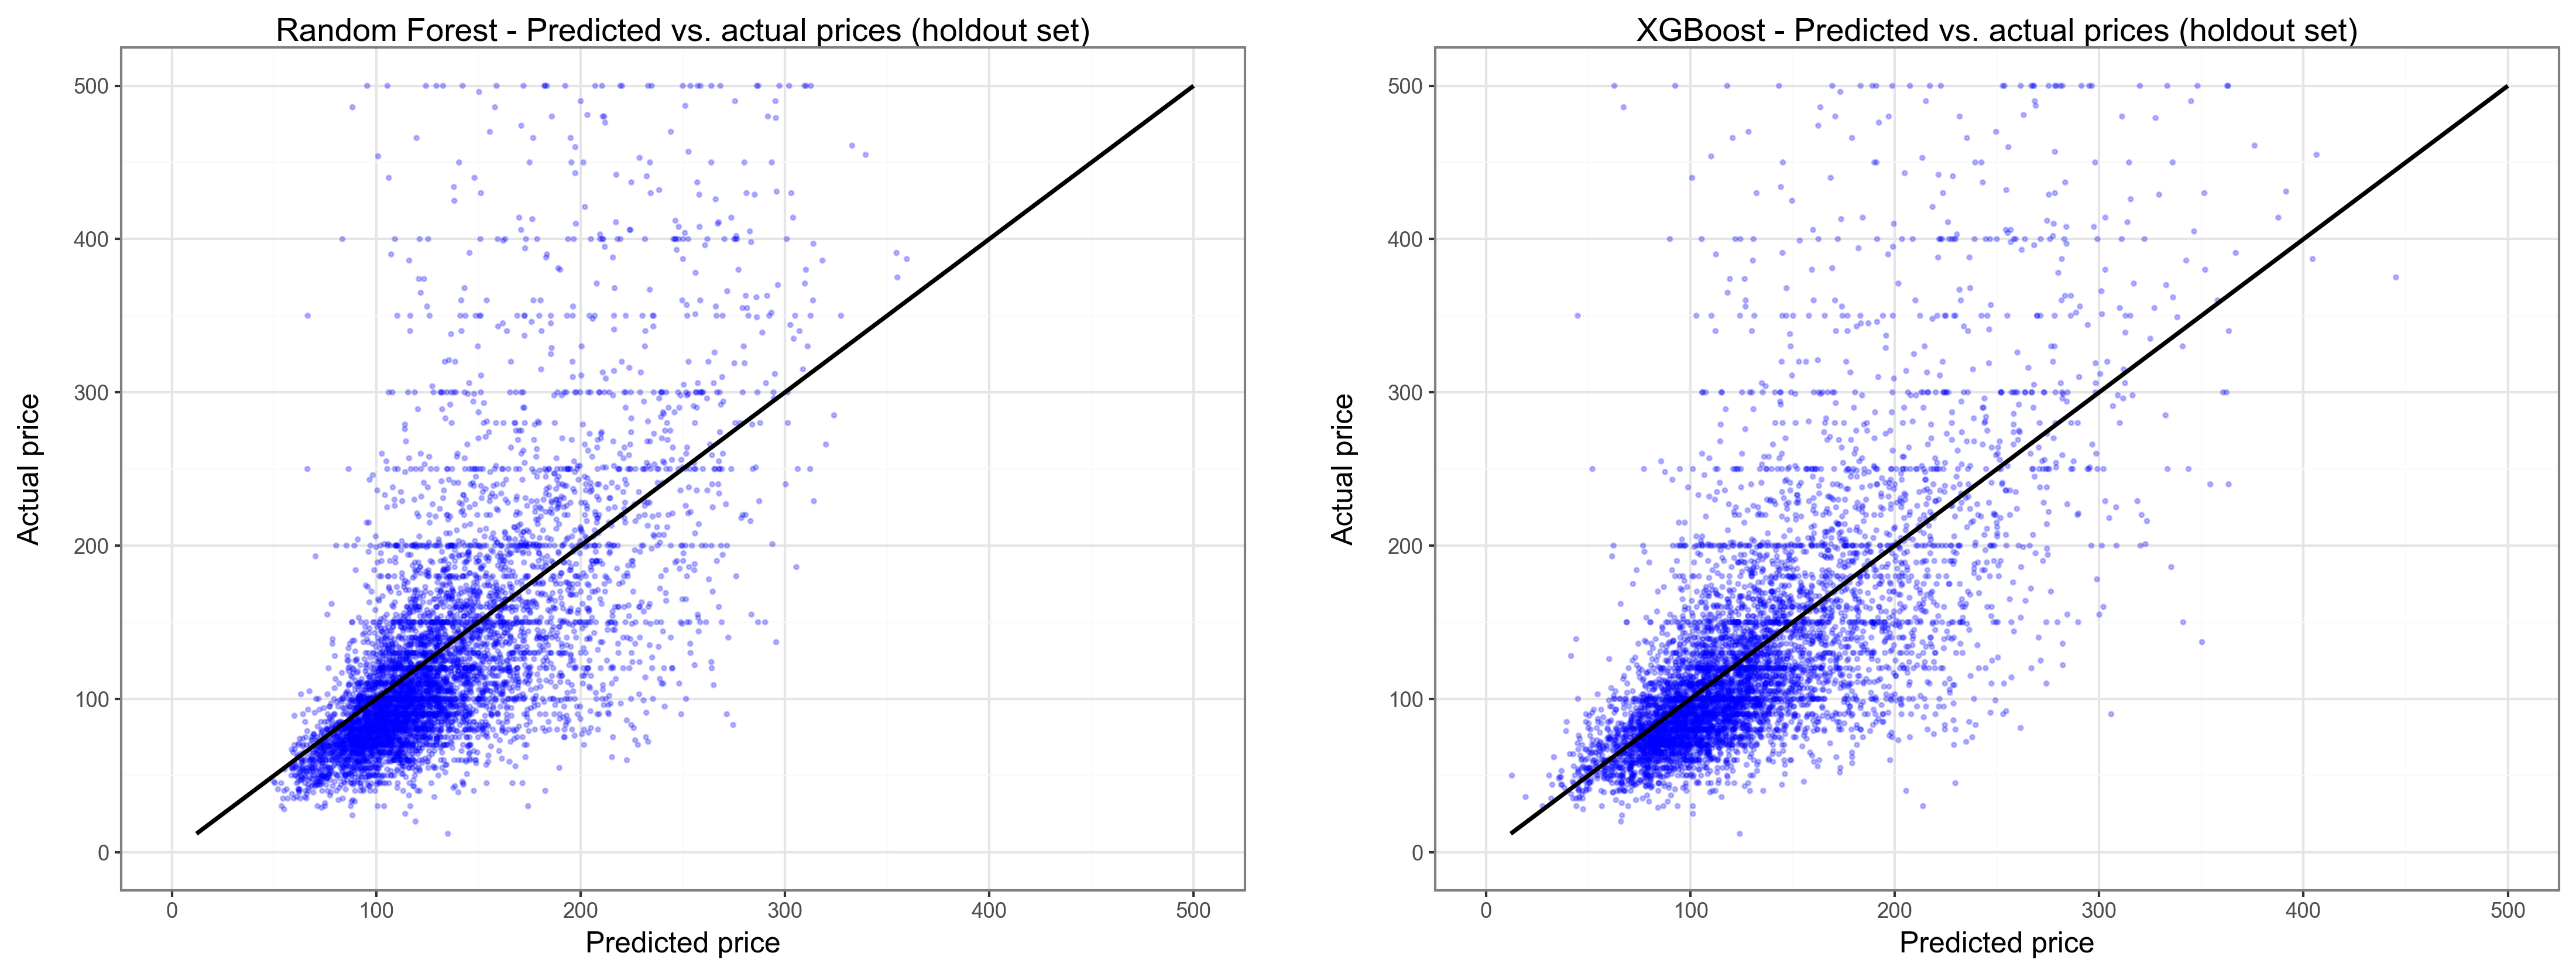

In [134]:
p1 = (
    ggplot(data_holdout_pred, aes(x="rf_pred", y="eur_price"))
    + geom_point(color='blue', size=0.5, alpha=0.25)
    + geom_line(aes(x="eur_price", y="eur_price"), color='black', size=1)
    + theme_bw()
    + labs(title='Random Forest - Predicted vs. actual prices (holdout set)',
           x='Predicted price', y='Actual price')
    + scale_x_continuous(limits=(0, 500), breaks=range(0, 501, 100))
    + scale_y_continuous(limits=(0, 500), breaks=range(0, 501, 100))
)

p2 = (
    ggplot(data_holdout_pred, aes(x="xgb_pred", y="eur_price"))
    + geom_point(color='blue', size=0.5, alpha=0.25)
    + geom_line(aes(x="eur_price", y="eur_price"), color='black', size=1)
    + theme_bw()
    + labs(title='XGBoost - Predicted vs. actual prices (holdout set)',
           x='Predicted price', y='Actual price')
    + scale_x_continuous(limits=(0, 500), breaks=range(0, 501, 100))
    + scale_y_continuous(limits=(0, 500), breaks=range(0, 501, 100))
)

pw.basefigure.clear()
display(pw.load_ggplot(p1) | pw.load_ggplot(p2))

In [135]:
print(f'RF mean prediction error (bias): {round(np.mean(data_holdout_pred.rf_pred - data_holdout_pred.eur_price),2)}')
print(f'XGB mean prediction error (bias): {round(np.mean(data_holdout_pred.xgb_pred - data_holdout_pred.eur_price),2)}')

RF mean prediction error (bias): 2.38
XGB mean prediction error (bias): -0.05


For both models, the predictions are relatively accurate for prices below 150 EUR. The dots are clustered closely around the diagonal line in this range. However, above 150 EUR, the spread of the dots widens significantly in both plots, indicating a decrease in prediction accuracy. This means both models struggle to accurately predict higher prices.

Comparing the two models, XGBoost appears to perform slightly better for higher prices. The scatter of dots around the diagonal line is less dispersed in the XGBoost plot compared to the Random Forest plot. However, in the lower price range, Random Forest might have a slight edge, as the dots seem more concentrated.

A noticeable pattern in the Random Forest plot is that it tends to overpredict prices. Many dots are located below the diagonal line, indicating that the model is consistently estimating higher prices than the actual ones. This observation is confirmed by the calculated mean prediction error (bias) of 2.38 for Random Forest, which is positive and suggests overprediction. In contrast, XGBoost has a mean prediction error of -0.05, close to zero, indicating a more balanced prediction.

There are a few data points that are significantly far from the diagonal line in both plots, which could be outliers or particularly difficult-to-predict items.

In summary, both models perform reasonably well for lower prices but struggle with higher prices. Random Forest consistently overpredicts, as confirmed by its positive bias, while XGBoost appears more balanced.

## Part 2: Validity
### 2.5. 'Live' dataset import and cleaning

This has already been done (see section 1.1).

### 2.6. Evaluating model performance on 'live' data

First, to utilize all available training data, I will re-estimate all models using the complete MilanQ2 dataset (that is, both the training and the hold-out set).

In [136]:
y, X = dmatrices("eur_price" + ols_equations[3], milanQ2)
ols_complete = LinearRegression().fit(X, y)

In [137]:
y, X = dmatrices("eur_price" + ols_equations[5], milanQ2)
lasso_best_pipeline.fit(X, y.ravel())

Pipeline(steps=[('scale', StandardScaler()),
                ('regressor',
                 ElasticNet(alpha=0.1, l1_ratio=1, random_state=9876))])

In [138]:
rf_best_pipeline.fit(milanQ2[list(predictors_ml)], milanQ2.eur_price)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['f_property_type',
                                                   'f_room_type', 'f_bathrooms',
                                                   'f_host_location',
                                                   'f_host_response_time',
                                                   'f_host_listings_count',
                                                   'f_number_of_reviews']),
                                                 ('num', 'passthrough',
                                                  ['n_accomodates',
                                                   'n_bedrooms', 'n_beds',
                                                   'n_distance_to_center',
                                                   'd_instant_bookable',
                                                   'n...
                                                   'd_amenities_heating',
                                                   'd_amenities_tv',
                                                   'd_amenities_hangers',
                                                   'd_amenities_wifi',
                                                   'd_amenities_kitchen',
                                                   'd_amenities_air_conditioning',
                                                   'd_amenities_elevator',
                                                   'd_amenities_essentials',
                                                   'd_amenities_first_aid_kit', ...])])),
                ('regressor',
                 RandomForestRegressor(max_features=16, min_samples_split=3,
                                       n_estimators=250, n_jobs=7,
                                       oob_score=True, random_state=485))])

In [139]:
gbm_best_pipeline.fit(milanQ2[list(predictors_ml)], milanQ2.eur_price)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['f_property_type',
                                                   'f_room_type', 'f_bathrooms',
                                                   'f_host_location',
                                                   'f_host_response_time',
                                                   'f_host_listings_count',
                                                   'f_number_of_reviews']),
                                                 ('num', 'passthrough',
                                                  ['n_accomodates',
                                                   'n_bedrooms', 'n_beds',
                                                   'n_distance_to_center',
                                                   'd_instant_bookable',
                                                   'n...
                                                   'flag_n_reviews_per_month',
                                                   'd_amenities_washer',
                                                   'd_amenities_heating',
                                                   'd_amenities_tv',
                                                   'd_amenities_hangers',
                                                   'd_amenities_wifi',
                                                   'd_amenities_kitchen',
                                                   'd_amenities_air_conditioning',
                                                   'd_amenities_elevator',
                                                   'd_amenities_essentials',
                                                   'd_amenities_first_aid_kit', ...])])),
                ('regressor',
                 GradientBoostingRegressor(max_depth=5, min_samples_split=20,
                                           n_estimators=200,
                                           random_state=31))])

In [140]:
xgb_best_pipeline.fit(milanQ2[list(predictors_ml)], milanQ2.eur_price)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['f_property_type',
                                                   'f_room_type', 'f_bathrooms',
                                                   'f_host_location',
                                                   'f_host_response_time',
                                                   'f_host_listings_count',
                                                   'f_number_of_reviews']),
                                                 ('num', 'passthrough',
                                                  ['n_accomodates',
                                                   'n_bedrooms', 'n_beds',
                                                   'n_distance_to_center',
                                                   'd_instant_bookable',
                                                   'n...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=6, max_leaves=None, min_child_weight=10,
                              missing=nan, monotone_constraints=None,
                              multi_strategy=None, n_estimators=450,
                              n_jobs=None, num_parallel_tree=None,
                              random_state=56, ...))])

Now we can make some predictions on the live datasets. Importantly, in a real use case, we would have no way to calculate RMSE values for the live data (as it would be live, without price values available). However, we now have price inside our live sets as well, so we can calculate the models' RMSE values there as well.

An important caveat, however, is that before, I intentionally did not filter out observations with possible errors or extreme values in the price variable (as in real live data, we could not do that). However, when calculating the RMSE values, these errors very much inflate the results. So, I below present two RMSE values for both datasets: one without filtering out erronous prices, and one with filtering these out. I believe this second measure captures much better how well my models generalize to other time periods or other areas.

In [141]:
milanQ3_rmse = {}
y, X = dmatrices("eur_price" + ols_equations[3], milanQ3)
milanQ3_rmse['ols'] = mean_squared_error(y, ols_complete.predict(X), squared = False)
y, X = dmatrices("eur_price" + ols_equations[5], milanQ3)
milanQ3_rmse['lasso'] = mean_squared_error(y, lasso_best_pipeline.predict(X), squared = False)
milanQ3_rmse['rf'] = mean_squared_error(milanQ3['eur_price'], rf_best_pipeline.predict(milanQ3[list(predictors_ml)]), squared = False)
milanQ3_rmse['gbm'] = mean_squared_error(milanQ3['eur_price'], gbm_best_pipeline.predict(milanQ3[list(predictors_ml)]), squared = False)
milanQ3_rmse['xgb'] = mean_squared_error(milanQ3['eur_price'], xgb_best_pipeline.predict(milanQ3[list(predictors_ml)]), squared = False)

In [142]:
milanQ3_clean = milanQ3[milanQ3['eur_price'] <= 500]

In [143]:
milanQ3_clean_rmse = {}
y, X = dmatrices("eur_price" + ols_equations[3], milanQ3_clean)
milanQ3_clean_rmse['ols'] = mean_squared_error(y, ols_complete.predict(X), squared = False)
y, X = dmatrices("eur_price" + ols_equations[5], milanQ3_clean)
milanQ3_clean_rmse['lasso'] = mean_squared_error(y, lasso_best_pipeline.predict(X), squared = False)
milanQ3_clean_rmse['rf'] = mean_squared_error(milanQ3_clean['eur_price'], rf_best_pipeline.predict(milanQ3_clean[list(predictors_ml)]), squared = False)
milanQ3_clean_rmse['gbm'] = mean_squared_error(milanQ3_clean['eur_price'], gbm_best_pipeline.predict(milanQ3_clean[list(predictors_ml)]), squared = False)
milanQ3_clean_rmse['xgb'] = mean_squared_error(milanQ3_clean['eur_price'], xgb_best_pipeline.predict(milanQ3_clean[list(predictors_ml)]), squared = False)

In [144]:
florenceQ2_rmse = {}
y, X = dmatrices("eur_price" + ols_equations[3], florenceQ2)
florenceQ2_rmse['ols'] = mean_squared_error(y, ols_complete.predict(X), squared = False)
y, X = dmatrices("eur_price" + ols_equations[5], florenceQ2)
florenceQ2_rmse['lasso'] = mean_squared_error(y, lasso_best_pipeline.predict(X), squared = False)
florenceQ2_rmse['rf'] = mean_squared_error(florenceQ2['eur_price'], rf_best_pipeline.predict(florenceQ2[list(predictors_ml)]), squared = False)
florenceQ2_rmse['gbm'] = mean_squared_error(florenceQ2['eur_price'], gbm_best_pipeline.predict(florenceQ2[list(predictors_ml)]), squared = False)
florenceQ2_rmse['xgb'] = mean_squared_error(florenceQ2['eur_price'], xgb_best_pipeline.predict(florenceQ2[list(predictors_ml)]), squared = False)

In [145]:
florenceQ2_clean = florenceQ2[florenceQ2['eur_price'] <= 500]

In [146]:
florenceQ2_clean_rmse = {}
y, X = dmatrices("eur_price" + ols_equations[3], florenceQ2_clean)
florenceQ2_clean_rmse['ols'] = mean_squared_error(y, ols_complete.predict(X), squared = False)
y, X = dmatrices("eur_price" + ols_equations[5], florenceQ2_clean)
florenceQ2_clean_rmse['lasso'] = mean_squared_error(y, lasso_best_pipeline.predict(X), squared = False)
florenceQ2_clean_rmse['rf'] = mean_squared_error(florenceQ2_clean['eur_price'], rf_best_pipeline.predict(florenceQ2_clean[list(predictors_ml)]), squared = False)
florenceQ2_clean_rmse['gbm'] = mean_squared_error(florenceQ2_clean['eur_price'], gbm_best_pipeline.predict(florenceQ2_clean[list(predictors_ml)]), squared = False)
florenceQ2_clean_rmse['xgb'] = mean_squared_error(florenceQ2_clean['eur_price'], xgb_best_pipeline.predict(florenceQ2_clean[list(predictors_ml)]), squared = False)

Let's first discuss validity on the Milan Q3 dataset! As mentioned before, I will concentrate on the RMSE values when the price errors have been removed.

First, note that the Milan Q3 RMSE values are higher for all models compared to their hold-out set performance. This suggests that none of the models fully capture the underlying structure of the new time period. The issue is particularly pronounced for the OLS, LASSO, and GBM models, meaning they struggle more with temporal shifts in the data. In contrast, Random Forest and XGBoost perform better in this setting, with Random Forest showing the strongest generalization to Milan Q3.

Now, turning to the Florence Q2 dataset, the RMSE values are even higher than those for Milan Q3, reinforcing the idea that adapting to a different city is more challenging than adapting to a different time period within the same city. This points to potential regional differences in the data that the models fail to capture. Interestingly, while Random Forest remains the best-performing model, the LASSO approach now ranks higher than XGBoost—suggesting that in some cases, a simpler linear model with regularization might be preferable over complex tree-based methods.

All in all, we can conclude that:

- Generalization to a new city is more difficult than generalization to a new time period in the same city.
- Random Forest consistently generalizes the best across both types of live datasets.
- The ranking of models changes when moving between time-based and location-based generalization, highlighting the importance of testing across multiple real-world scenarios.

Thus, if we were to deploy one of these models in a real-world setting, I would recommend using Random Forest. It provides the best balance between performance and adaptability while avoiding the potential overfitting risks of more complex boosting-based models. Additionally, it is computationally more efficient than XGBoost and GBM, making it a practical choice for both training and inference.

In [147]:
live_rmse = pd.DataFrame({
    'Milan Q3 RMSE' : milanQ3_rmse,
    'Milan Q3 RMSE (price errors removed)' : milanQ3_clean_rmse,
    'Florence Q2 RMSE' : florenceQ2_rmse,
    'Florence Q2 RMSE (price errors removed)' : florenceQ2_clean_rmse
}).round(2)

live_rmse.index = ['OLS', 'LASSO', 'Random Forest', 'GBM', 'XGBoost']

live_rmse['CV test RMSE'] = horserace['CV test RMSE']
live_rmse['Hold-out set RMSE'] = horserace['Hold-out set RMSE']

live_rmse = live_rmse[['CV test RMSE', 'Hold-out set RMSE', 
                       'Milan Q3 RMSE', 'Milan Q3 RMSE (price errors removed)', 
                       'Florence Q2 RMSE', 'Florence Q2 RMSE (price errors removed)']]

live_rmse

CV test RMSE  Hold-out set RMSE  Milan Q3 RMSE  \
OLS                   61.77              62.67        1132.74   
LASSO                 61.72              62.22        1132.73   
Random Forest         60.00              59.70        1132.02   
GBM                   59.09              58.98        1132.17   
XGBoost               58.57              58.17        1132.20   

               Milan Q3 RMSE (price errors removed)  Florence Q2 RMSE  \
OLS                                           71.83            266.97   
LASSO                                         71.33            267.55   
Random Forest                                 61.54            269.45   
GBM                                           67.84            266.10   
XGBoost                                       66.31            265.66   

               Florence Q2 RMSE (price errors removed)  
OLS                                              69.09  
LASSO                                            68.01  
Random Forest                                    67.26  
GBM                                              69.38  
XGBoost                                          68.31

Lastly, we can also take a look at the above RMSE values in relative terms, that is expressing each of them as a proportion of their respective sample mean (just as we have done when we were looking at the subsample performance of the models). This may be more informative, as larger RMSE values are natural if e.g. the live dataset has generally larger prices.

What we can observe here is that the above noted loss of performance on the *live* datasets could be simply because these samples have a larger expected price value than what the model was trained on. Therefore, in relative terms, the models actually perform just as good or even better than what we have seen during cross-validation or on the hold-out set. This may be just by chance, but this could also indicate that the models could not learn all patterns in the original dataset, thus there may some more room for improvement.

In [151]:
live_norm_rmse = pd.DataFrame({
    'CV test RMSE' : live_rmse['CV test RMSE'] / data_train.eur_price.mean(),
    'Hold-out set RMSE' : live_rmse['Hold-out set RMSE'] / data_holdout.eur_price.mean(), 
    'Milan Q3 RMSE' : live_rmse['Milan Q3 RMSE'] / milanQ3.eur_price.mean(),
    'Milan Q3 RMSE (price errors removed)' : live_rmse['Milan Q3 RMSE (price errors removed)'] / milanQ3_clean.eur_price.mean(), 
    'Florence Q2 RMSE' : live_rmse['Florence Q2 RMSE'] / florenceQ2.eur_price.mean(),
    'Florence Q2 RMSE (price errors removed)' : live_rmse['Florence Q2 RMSE (price errors removed)'] / florenceQ2_clean.eur_price.mean()
}, index = live_rmse.index).round(4)
live_norm_rmse

CV test RMSE  Hold-out set RMSE  Milan Q3 RMSE  \
OLS                  0.4633             0.4724         5.1803   
LASSO                0.4629             0.4691         5.1803   
Random Forest        0.4500             0.4501         5.1770   
GBM                  0.4432             0.4446         5.1777   
XGBoost              0.4393             0.4385         5.1778   

               Milan Q3 RMSE (price errors removed)  Florence Q2 RMSE  \
OLS                                          0.4669            1.2810   
LASSO                                        0.4636            1.2838   
Random Forest                                0.4000            1.2929   
GBM                                          0.4409            1.2769   
XGBoost                                      0.4310            1.2747   

               Florence Q2 RMSE (price errors removed)  
OLS                                             0.4087  
LASSO                                           0.4023  
Random Forest                                   0.3978  
GBM                                             0.4104  
XGBoost                                         0.4040